# Usage of Costs Prediction Model - No Missing Data / Gaps filled out

# Load Libraries

In [14]:
# Cargar librerias
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
from dateutil.relativedelta import relativedelta
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.pylab import rcParams 
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBRegressor, plot_importance 


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, RidgeCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import scipy.stats as stats 
from scipy.stats import norm, skew
import scikitplot as skplt

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_info_rows', 100)

# to make this notebook's output identical at every run
np.random.seed(42)

# Function Definitions

In [8]:
def save_data(df, file_name):
    # Write data to CSV File
    df.to_csv(path_or_buf=file_name, sep=',',index=False, encoding='utf-8')
    return

def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', index_col=False, header='infer', float_precision=2 )
    return df

def draw_col_shape(df_feature,cols):
    # draw a bar graph with he number of members of a columns specify in field Cols
    
    # Dictionary for X Axis Labels
    dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
                 'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
                 'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
                 'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
                 'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
                 'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type',
                 'tenure':'Tenure Range', 'generation':'Generation', 'total_calls':'Total Breakdown Calls', 'aaa_mortgage':'Used Mortgage Service',
                  'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service','aaa_travel':'Travel Services',
                 'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
                 'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle','total_member_cost':'Total Member Avg. Costs',
                 'no_members':'Total Members with Household', 'aaa_id_theft':'ID Theft Service', 'use_road_side':'Use Roadside'
                }


    # number of members per state

    for col in cols:
        counts = df_feature[col].value_counts()
        sns.set(style="whitegrid")
        plt.axhline(0, color="k", clip_on=False)
        plt.ylabel("# of Classes",fontsize=14, fontweight='bold')
        plt.xlabel("Classes", fontsize=14, fontweight='bold')
        plt.title('Total  Number of Classes',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
        sns.barplot(counts.index, counts.values)
        plt.xticks(
            rotation=45, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='large')
        i = 0
        for v in list(counts.index):
            plt.text(i-.25, counts.values[v], str(counts.values[v]), color='blue', fontweight='bold')
            i +=1
        plt.show()
        counts = pd.DataFrame(df_feature[col].value_counts().nlargest(15), index=None)
        counts.reset_index(inplace=True)
        counts.rename(columns={"index": dict_cols[col], col: "# of Classes"}, inplace=True)
        fig = ff.create_table(counts, height_constant=30, index=False)
        py.iplot(fig)
        return

def cross_entropy(predictions, targets, epsilon=1e-10):
    # To calculate the cross Entropy Loss to validate model performance
    # Cross Entropy Loss
        # Cross-entropy loss, or log loss, measures the performance of a classification model 
        # whose output is a probability value between 0 and 1. #
        # Cross-entropy loss increases as the predicted probability diverges from the actual label. 
        # So predicting a probability of .012 when the actual observation label is 1 would be bad and 
        # result in a high loss value. # A perfect model would have a log loss of 0.
        
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce_loss = -np.sum(np.sum(targets * np.log(predictions + 1e-5)))/N
    return ce_loss

def road_side_usage(calls):
    if calls > 0: return 1
    elif calls == 0: return 0
    else: return np.nan


# Load data from consolidate file by household key and transacton file 

In [9]:
# Load data from the View create using Capstone AAA - EDA .ipynb
df_household = pd.read_csv('household_view_no_gaps.csv', parse_dates=True,infer_datetime_format=True)
df_transaction = pd.read_csv('capstone_aaa_featured_no_gaps.csv', 
                             parse_dates=['sc_date', 'birth_date_mmddyyyy', 'call_status_recv_date',
                                         'date_of_birth','active_expiration_date', 'cancel_date',
                                         'join_aaa_date', 'join_club_date', 'reinstate_date'
                                         ], 
                             infer_datetime_format=True)
df_original_house_hold = df_household.copy()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
var_to_predict = ['total_cost']
var_to_predict_title = 'Total Costs Forecast - No Date Gaps'
var_to_predict_save = 'totc_no_gap'
test_size = 0.5
# Create roadside usage
df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))
df_household.consumer_score = np.where(df_household.consumer_score!= np.nan, 1/df_household.consumer_score, 
                                    df_household.consumer_score)
df_household.consumer_score = np.where(df_household.consumer_score== np.nan, df_household.consumer_score.mean(), 
                                    df_household.consumer_score)
# Remove members with status CANCELLED
df_household = df_household[df_household.member_status!='CANCELLED']
df_transaction.call_status_recv_date = df_transaction.sc_date

In [10]:
df_transaction.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26006 entries, 0 to 26005
Data columns (total 167 columns):
id                                26006 non-null int64
individual_key                    26006 non-null int64
household_key                     26006 non-null int64
member_flag                       26006 non-null int64
city                              26006 non-null object
state_grouped                     26006 non-null object
zip5                              26006 non-null int64
zip9                              26006 non-null int64
fsv_cmsi_flag                     26006 non-null int64
fsv_credit_card_flag              26006 non-null int64
fsv_deposit_program_flag          26006 non-null int64
fsv_home_equity_flag              26006 non-null int64
fsv_id_theft_flag                 26006 non-null int64
fsv_mortgage_flag                 26006 non-null int64
ins_client_flag                   26006 non-null int64
trv_globalware_flag               26006 non-null int64
number_o

# Analysis the Total cost series

In [11]:
df_household.head()

membership_id  household_key       income member_status state_grouped credit_ranges cancel_reason renew_method plus_indicator_description   zip sc_vehicle_manufacturer_name sc_vehicle_model_name                          race  home_owner     education                             dwelling_type   gender occupation_code                  occupation_group occupant_type    mosaic_household  mosaic_global_household kcl_b_ind_mosaicsgrouping                  generation                 tenure  aaa_no_tenure  aaa_member_tenure_years  aaa_mean_age  length_of_residence  aaa_mortgage  aaa_credit_card  aaa_deposit  aaa_home_equity  aaa_financial_service  aaa_auto_insurance  aaa_id_theft  aaa_motorcycle_indicator  aaa_travel  aaa_mean_child  aaa_mean_total_cost  aaa_no_race  aaa_no_home_owner  aaa_no_education  aaa_no_income  aaa_no_dwelling_type  aaa_no_credit_ranges  aaa_no_gender  aaa_no_language  aaa_no_reason_joined  aaa_cancel_reason  aaa_no_mosaic_household  aaa_no_mosaic_global_household  \
0            153        4500791    30-39,999        ACTIVE            RI       600-649       UNKNOWN   AUTO RENEW           BASIC MEMBERSHIP  2893                       TOYOTA                 CAMRY   CAUCASION / WHITE - ENGLISH  HOME OWNER  SOME COLLEGE  SMALL OR LARGE MULTI-FAMILY W/APT NUMBER  UNKNOWN         UNKNOWN                           UNKNOWN       UNKNOWN    SENIOR DISCOUNTS        LOW INCOME ELDERS     GOLDEN YEAR GUARDIANS           POST-WAR (< 1948)              +40 YEARS              0                       49       97.0000              15.0000             0                1            0                0                      0                   0             0                    0.0000           0          2.0000              34.7917       2.0000             0.0000            1.0000         8.0000                2.0000                5.0000            nan           0.0000                   nan                nan                  11.0000                          7.0000   
2            163       11622991    50-59,999        ACTIVE            RI       750-799       UNKNOWN   AUTO RENEW           BASIC MEMBERSHIP  2889                       SUBARU                   BRZ    HISPANIC - HISPANIC ORIGIN  HOME OWNER       UNKNOWN                                      SFDU  UNKNOWN         UNKNOWN                           UNKNOWN       UNKNOWN  NO PLACE LIKE HOME  ROUTINE SERVICE WORKERS          THRIVING BOOMERS    MILLENIALS (1981 - 1993)    BETWEEN 1 & 5 YEARS              6                       59       47.3636               8.6364             0                0            0                0                      0                   0             0                    1.0000           0          1.0000              39.5318       6.0000             0.0000            2.0000         4.0000                0.0000                1.0000            nan           0.0000                   nan             1.0000                   3.0000                          3.0000   
3            182         579810    50-59,999        ACTIVE            RI       650-699       UNKNOWN       NOTICE           BASIC MEMBERSHIP  2863                     INFINITI                  QX56  CAUCASION / WHITE - EUROPEAN  HOME OWNER  SOME COLLEGE                                      SFDU     MALE         RETIRED                   RETIRED - KNOWN       UNKNOWN         TOWN ELDERS   COMFORTABLE RETIREMENT     GOLDEN YEAR GUARDIANS           POST-WAR (< 1948)              +40 YEARS              0                       59       83.0000              15.0000             0                0            0                0                      0                   1             0                    0.0000           0          1.0000              28.0000       1.0000             0.0000            1.0000         4.0000                0.0000                3.0000         2.0000           0.0000                   nan                nan                   6.0000                          1.0000   

In [15]:
df_household[var_to_predict[0]].describe()

count   2961.0000
mean     217.5110
std      276.4544
min        0.0000
25%       32.5000
50%      123.0000
75%      293.0000
max     2576.7000
Name: total_cost, dtype: float64


 mu = 217.51 and sigma = 276.41



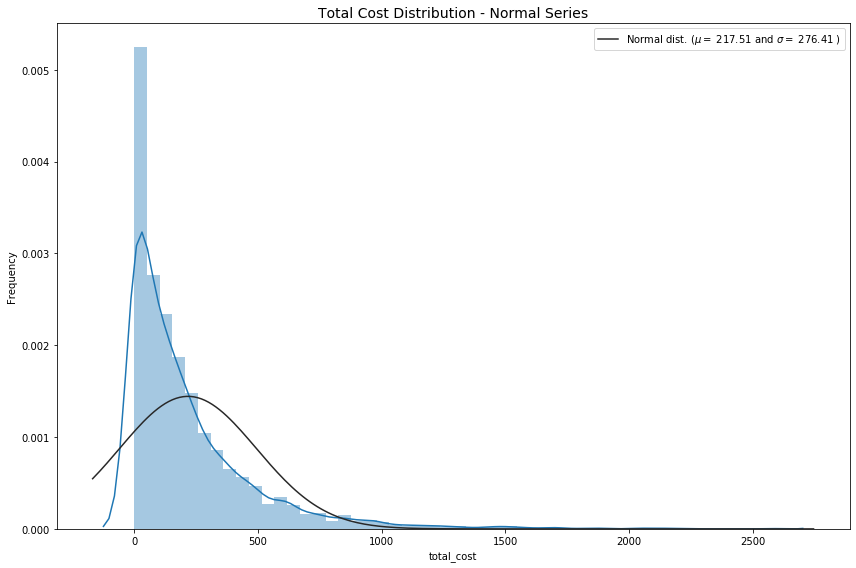

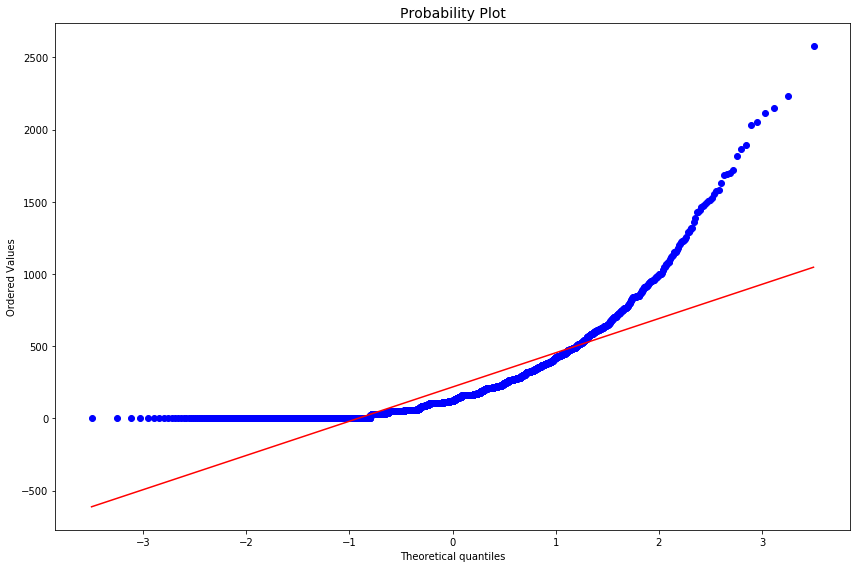

In [16]:
df = pd.DataFrame(df_household,columns=var_to_predict)

sns.distplot(df[var_to_predict[0]] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[var_to_predict[0]])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total Cost Distribution - Normal Series')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[var_to_predict[0]], plot=plt)
plt.show()


 mu = 4.10 and sigma = 2.28



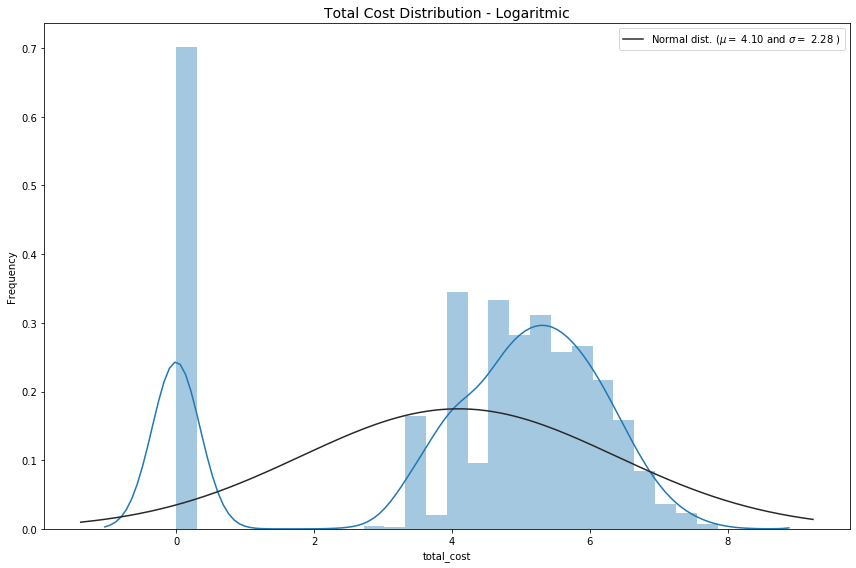

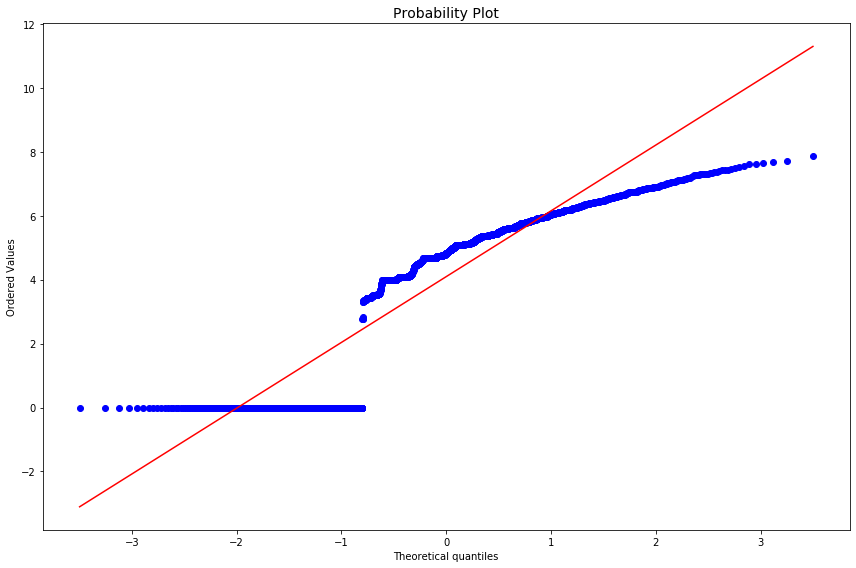

In [17]:
# Logaritmic
df = pd.DataFrame(df_household,columns=var_to_predict)

df[var_to_predict[0]] = np.log1p(df[var_to_predict[0]])

sns.distplot(df[var_to_predict[0]] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[var_to_predict[0]])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total Cost Distribution - Logaritmic')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[var_to_predict[0]], plot=plt)
plt.show()


 mu = 0.00 and sigma = 1.00



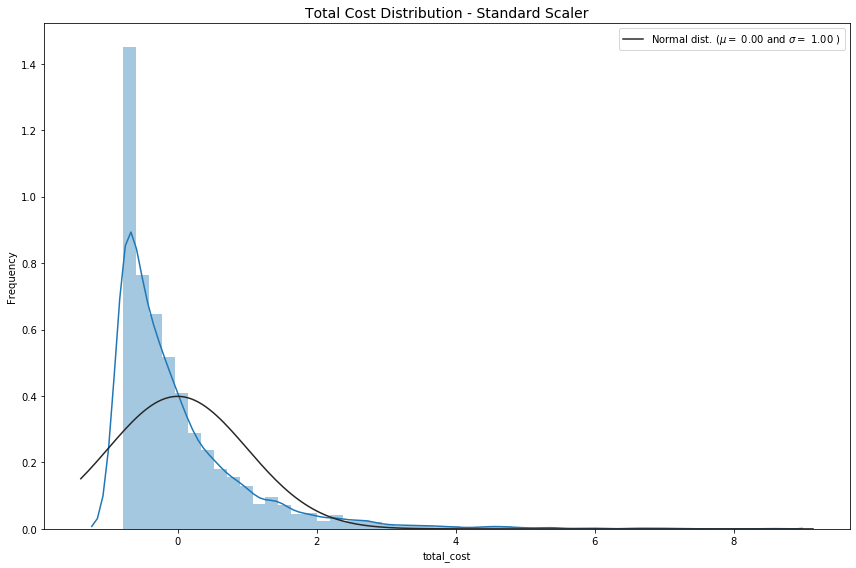

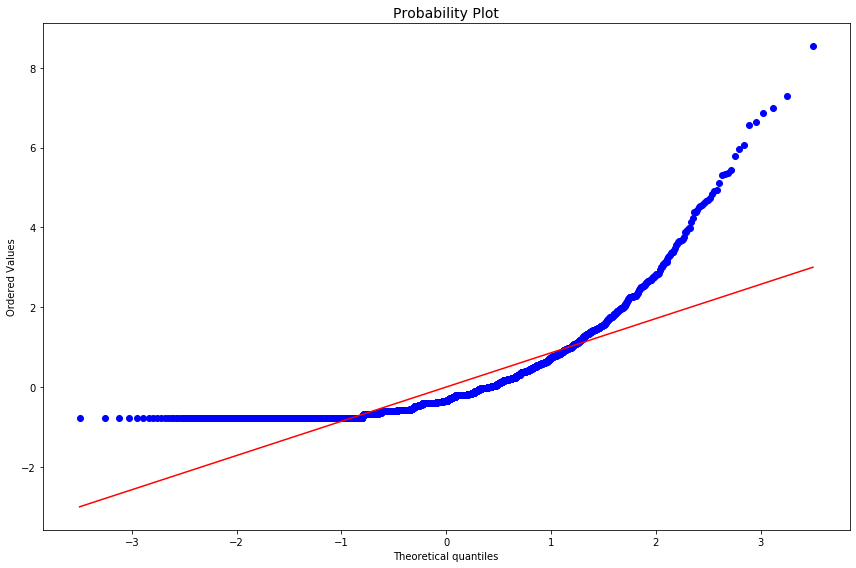

In [18]:
# Standard Scaler

df = pd.DataFrame(df_household,columns=var_to_predict)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

df = scaled_df.copy()
sns.distplot(df[var_to_predict[0]] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[var_to_predict[0]])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total Cost Distribution - Standard Scaler')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[var_to_predict[0]], plot=plt)
plt.show()


 mu = 0.08 and sigma = 0.11



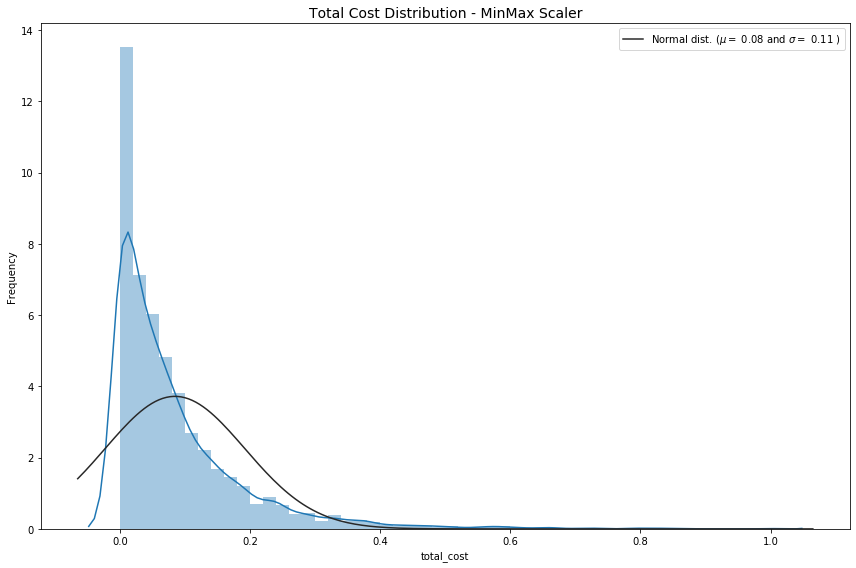

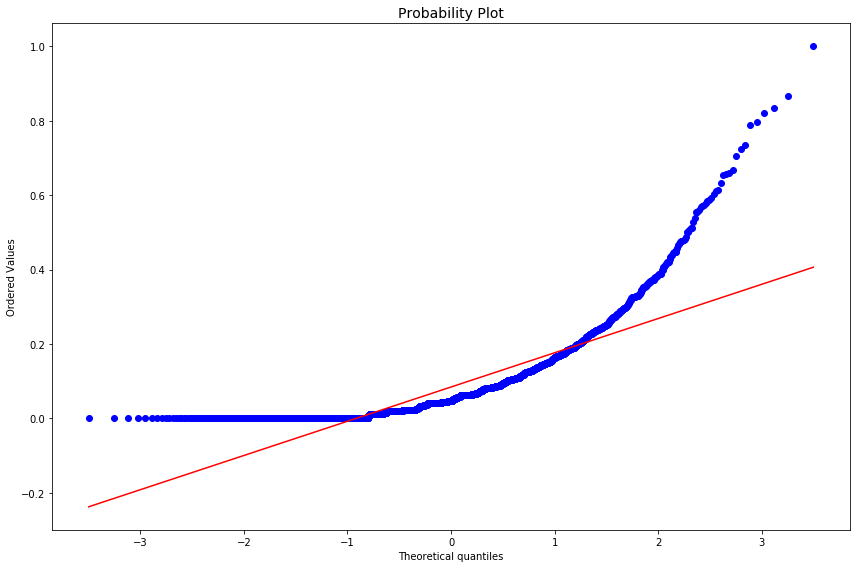

In [19]:
# MinMax Scaler

df = pd.DataFrame(df_household,columns=var_to_predict)
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

df = scaled_df.copy()
sns.distplot(df[var_to_predict[0]] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[var_to_predict[0]])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total Cost Distribution - MinMax Scaler')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[var_to_predict[0]], plot=plt)
plt.show()


 mu = 0.36 and sigma = 1.06



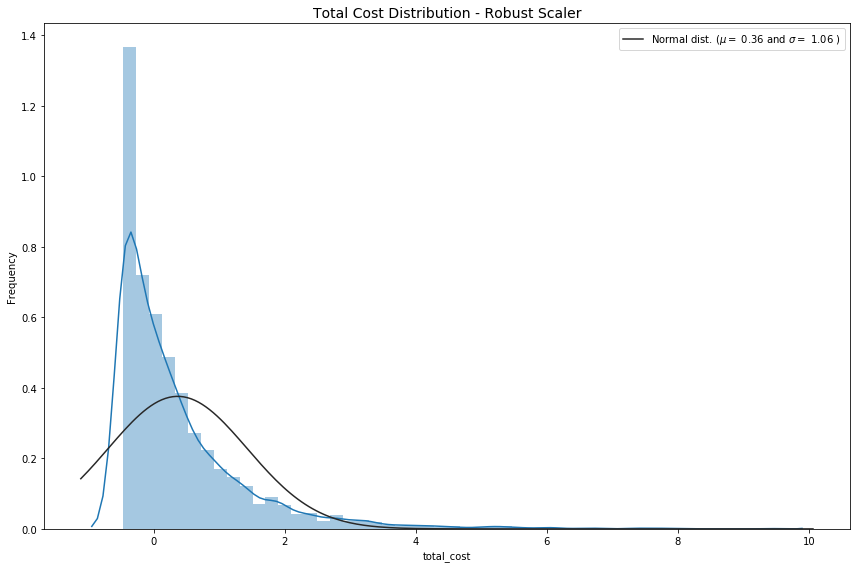

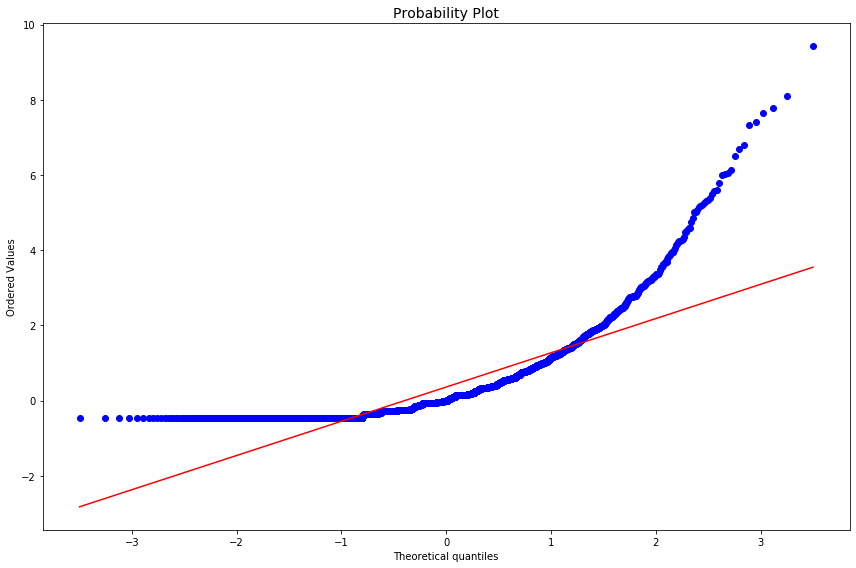

In [20]:
# Robust Scaler

df = pd.DataFrame(df_household,columns=var_to_predict)
scaler = RobustScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

df = scaled_df.copy()
sns.distplot(df[var_to_predict[0]] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[var_to_predict[0]])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total Cost Distribution - Robust Scaler')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[var_to_predict[0]], plot=plt)
plt.show()


 mu = 0.00 and sigma = 1.00



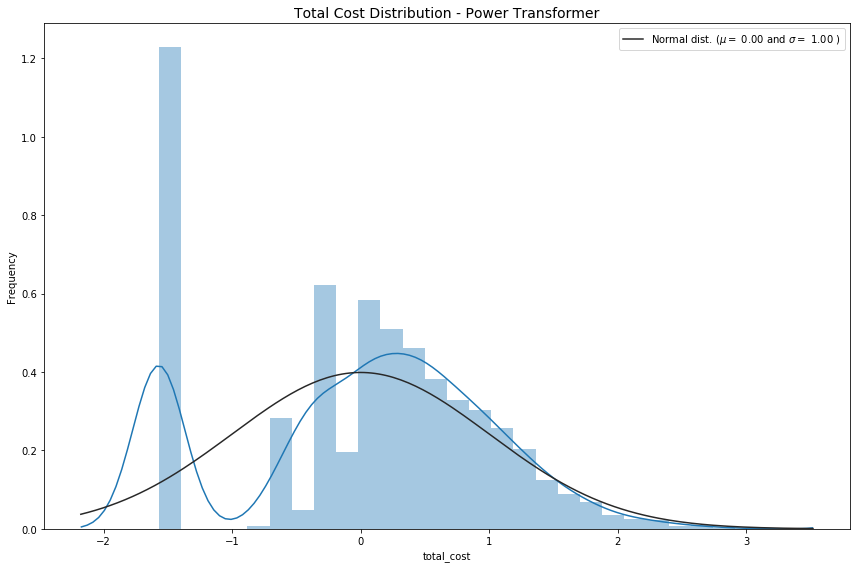

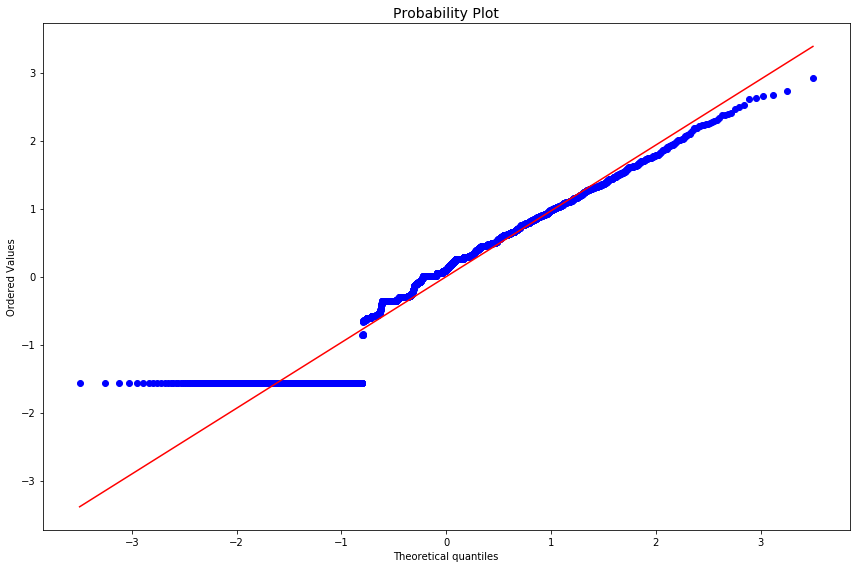

In [21]:
# Power Transformer

df = pd.DataFrame(df_household,columns=var_to_predict)
scaler = PowerTransformer()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

df = scaled_df.copy()
sns.distplot(df[var_to_predict[0]] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[var_to_predict[0]])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total Cost Distribution - Power Transformer')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[var_to_predict[0]], plot=plt)
plt.show()


 mu = 0.79 and sigma = 0.41



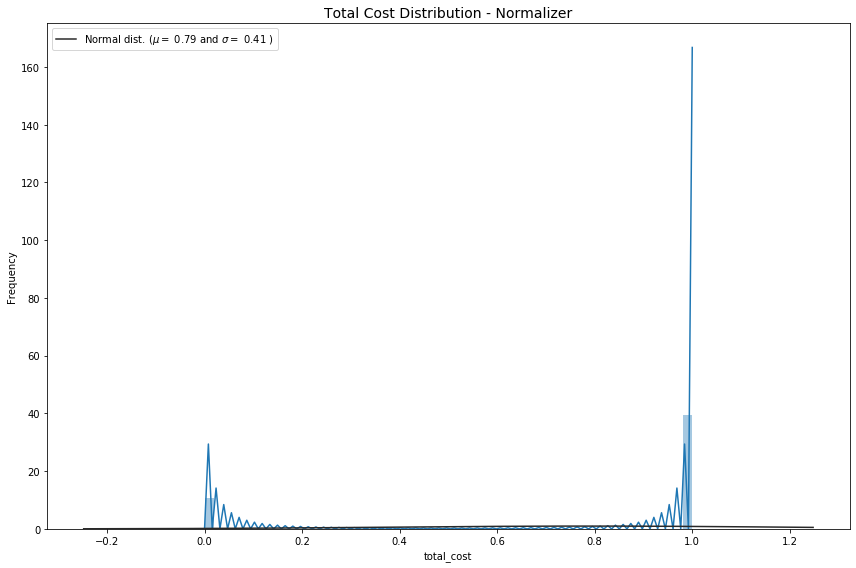

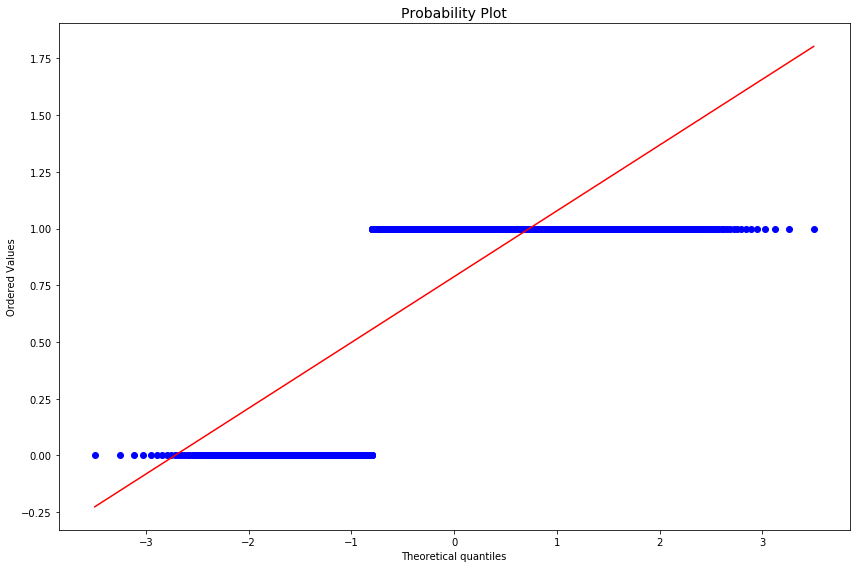

In [22]:
# Normalizer Transformer

df = pd.DataFrame(df_household,columns=var_to_predict)
scaler = Normalizer()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

df = scaled_df.copy()
sns.distplot(df[var_to_predict[0]] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[var_to_predict[0]])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total Cost Distribution - Normalizer')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[var_to_predict[0]], plot=plt)
plt.show()


 mu = 0.08 and sigma = 0.11



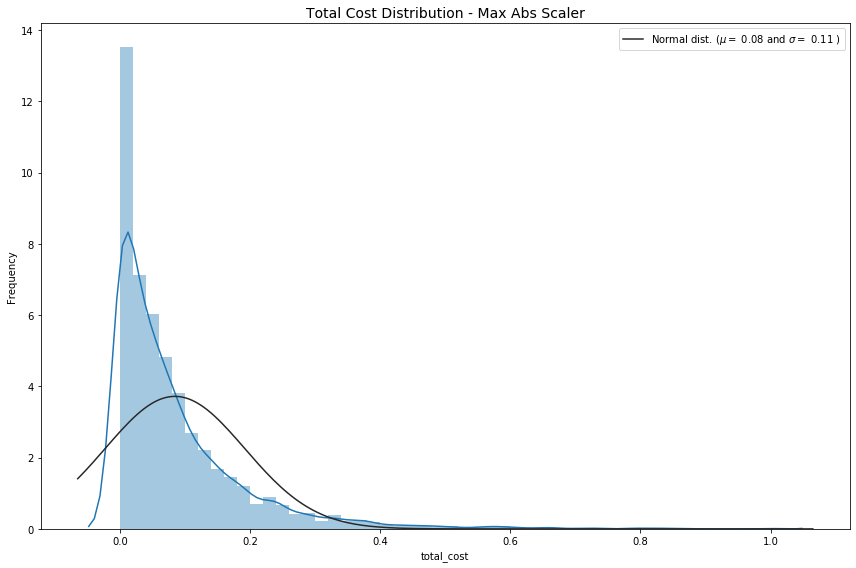

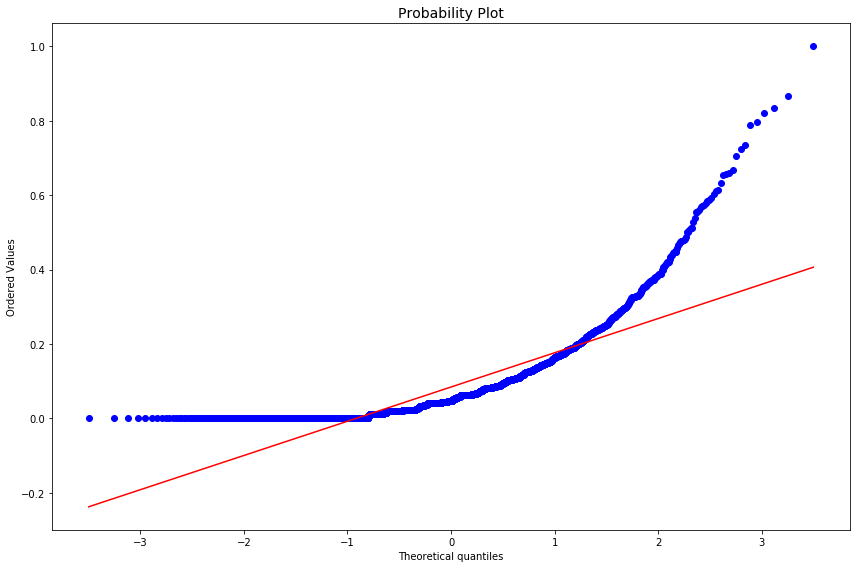

In [23]:
# Max Abs transformer

df = pd.DataFrame(df_household,columns=var_to_predict)
scaler = MaxAbsScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

df = scaled_df.copy()
sns.distplot(df[var_to_predict[0]] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[var_to_predict[0]])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total Cost Distribution - Max Abs Scaler')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[var_to_predict[0]], plot=plt)
plt.show()


 mu = 0.48 and sigma = 0.32



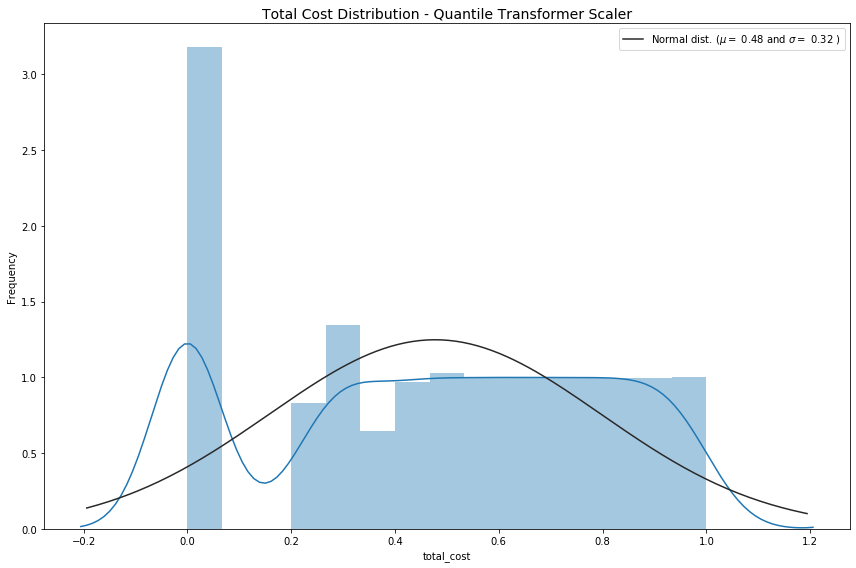

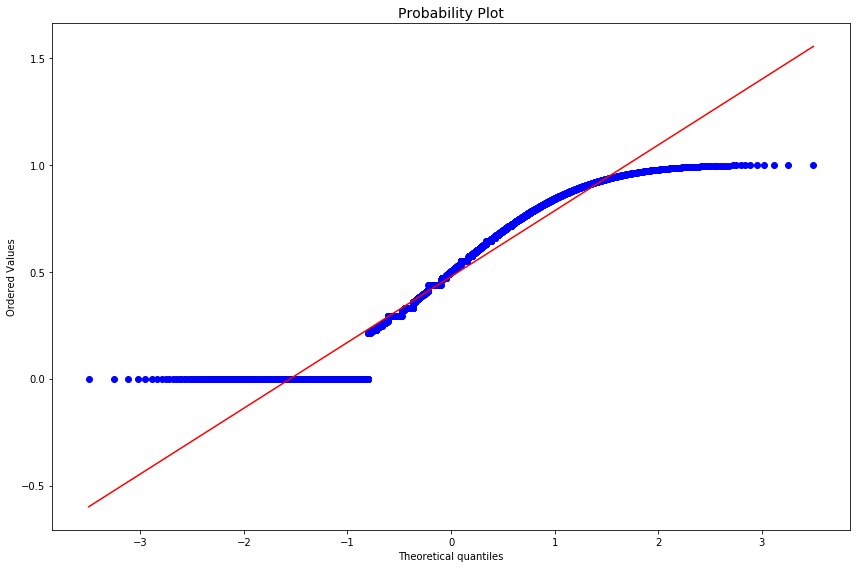

In [24]:
# Quantile Transformer Scaler

df = pd.DataFrame(df_household,columns=var_to_predict)
scaler = QuantileTransformer(1000,'uniform')
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

df = scaled_df.copy()
sns.distplot(df[var_to_predict[0]] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[var_to_predict[0]])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total Cost Distribution - Quantile Transformer Scaler')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[var_to_predict[0]], plot=plt)
plt.show()

# Cars that are most likely to break down 
https://247wallst.com/special-report/2019/12/12/these-new-cars-are-most-likely-to-break-down/2/

# Top Car 35 Car brand according to consumer reports
https://www.autonews.com/retail/subaru-reaches-top-consumer-reports-rankings-tesla-falters


In [25]:
df_group_veh_manuf = df_transaction.groupby(by='sc_vehicle_manufacturer_name').agg(({'total_calls':sum, 
                                                                                     'total_cost' :['sum','mean']
                                                                                    }))

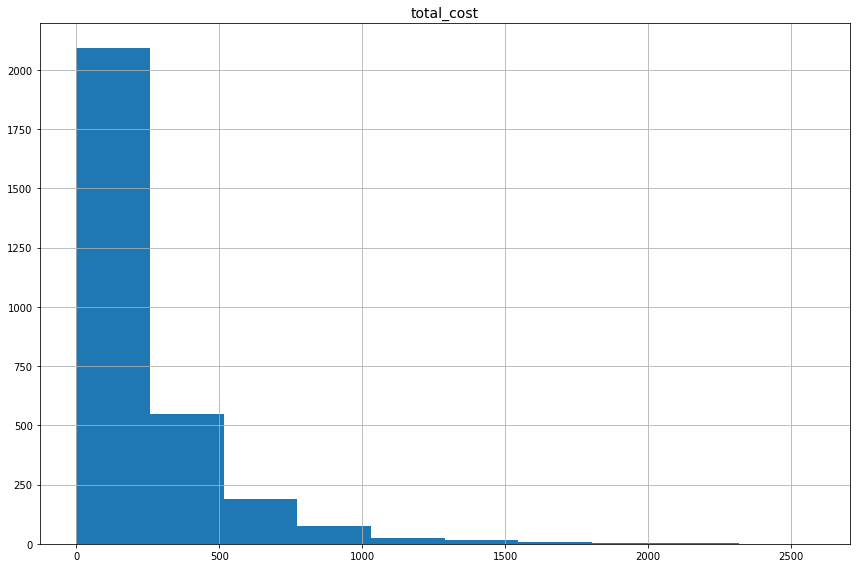

In [26]:
df_household[var_to_predict].hist(figsize=(12,8))
plt.show()

In [27]:
# Gender
fig = px.scatter(df_household, x=var_to_predict[0], y="total_calls", marginal_x="box", 
                 marginal_y="box", trendline="ols", facet_col="gender",color="gender",
                 color_continuous_scale=px.colors.sequential.Viridis, render_mode="webgl"
                )
fig.show()


In [28]:
# Gender / tenure
fig = px.scatter(df_household, x=var_to_predict[0], y="total_calls", marginal_x="box", 
                 marginal_y="box", trendline="ols", color="tenure",facet_col="gender",
                 color_continuous_scale=px.colors.sequential.Viridis, render_mode="webgl"
                )
fig.show()


In [29]:
df_transaction.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26006 entries, 0 to 26005
Data columns (total 167 columns):
id                                int64
individual_key                    int64
household_key                     int64
member_flag                       int64
city                              object
state_grouped                     object
zip5                              int64
zip9                              int64
fsv_cmsi_flag                     int64
fsv_credit_card_flag              int64
fsv_deposit_program_flag          int64
fsv_home_equity_flag              int64
fsv_id_theft_flag                 int64
fsv_mortgage_flag                 int64
ins_client_flag                   int64
trv_globalware_flag               int64
number_of_children                object
responded_to_catalog              object
race                              object
length_of_residence               int64
mail_responder                    object
home_owner                        object
inc

In [30]:
df_household.groupby(by=var_to_predict[0]).mean()

membership_id  household_key       zip  aaa_no_tenure  aaa_member_tenure_years  aaa_mean_age  length_of_residence  aaa_mortgage  aaa_credit_card  aaa_deposit  aaa_home_equity  aaa_financial_service  aaa_auto_insurance  aaa_id_theft  aaa_motorcycle_indicator  aaa_travel  aaa_mean_child  aaa_mean_total_cost  aaa_no_race  aaa_no_home_owner  aaa_no_education  aaa_no_income  aaa_no_dwelling_type  aaa_no_credit_ranges  aaa_no_gender  aaa_no_language  aaa_no_reason_joined  aaa_cancel_reason  aaa_no_mosaic_household  aaa_no_mosaic_global_household  aaa_no_kcl_b_ind_mosaicsgrouping  aaa_no_occupation_code  aaa_no_occupation_group  aaa_no_occupant_type  aaa_no_plus_indicator_description  aaa_no_generation  total_calls_year_1  total_calls_year_2  total_calls_year_3  total_member_cost_1  total_member_cost_2  total_member_cost_3  basic_cost  plus_cost  premier_cost  mean_basic_cost  mean_plus_cost  mean_premier_cost  total_calls  total_member_cost  mean_total_member_cost  \
total_cost                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
0.0000        117960.8102  14731824.0925 2885.5407         0.9617                  46.8628       74.7576               7.7303        0.0526           0.1244       0.0128           0.0016                 0.0526              0.2775        0.0622                    0.4762      0.1738          1.5104               0.0000       2.4382             0.0595            1.9919         4.7224                0.4021                2.4712         1.5214           0.1012                3.2000             3.6390                   8.4638                          2.7766                            3.8681                  7.1593                   4.9095                1.3158                             1.1379             0.6318              0.0239              0.1675              0.3190               0.9114               8.5742              15.4026      0.0000     0.0000        0.0000           0.0000          0.0000             0.0000       0.5104            24.8882                 14.3890   
15.0000       377560.6667   6438447.3333 4076.0000         0.3333                  54.0000       68.4445               7.2222        0.0000           0.3333       0.0000           0.0000                 0.0000              0.0000        0.0000                    0.6667      0.0000          1.3333               5.4167       3.3333             0.0000            2.0000         5.6667                1.3333                2.0000         2.0000           0.0000                   nan             5.0000                  19.3333                          5.0000                            9.0000                  9.0000                   9.0000                1.0000                             0.6667             2.3333              0.0000              0.0000              0.6667               0.0000               0.0000              35.3333     15.0000     0.0000        0.0000           5.4167          0.0000             0.0000       0.6667            35.3333                 17.6667   
16.2500        16706.0000   2128311.0000 2864.0000         4

In [31]:
fig = px.scatter(df_household, x=var_to_predict[0], y="total_calls", size="total_calls", color="generation",
           hover_name="plus_indicator_description", log_x=True, size_max=60)
fig.show()

In [32]:
fig = px.bar(df_household, x='income', y=var_to_predict[0],
             hover_data=["plus_indicator_description", 'gender'], color="plus_indicator_description",
             labels={'total_calls':'Total Roadside Calls'}, height=600)
fig.show()

In [33]:
# Number of members in household key
df_household.total_members_in_household.value_counts()

2     1039
1      723
3      601
4      366
5      158
6       44
7       26
8        2
15       1
9        1
Name: total_members_in_household, dtype: int64

In [34]:
# Income
df_household.income.value_counts()

UNKNOWN          717
100-149,999      489
90-99,999        443
50-59,999        199
70-79,999        195
40-49,999        143
10-19,999        129
175 - 199,999    109
60-69,999        101
30-39,999         94
150 - 174,999     89
20-29,999         78
200 - 249,999     69
250K+             68
UNDER 10K         36
80-89,999          2
Name: income, dtype: int64

# Outcomes
The frequency of id theft Service use depend heavvily on income. 
Will consolidate income in three categories: 
    * a) under 10k - 39999: Under 39.999
    * b) 40 - 99,999 : 40 - 99,999
    * c) 100k and above : 100+
    

In [35]:
group1 = ['UNDER 10K', '10-19,999','20-29,999', '30-39,999']
group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
for i in group1:
    df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
for i in group2:
    df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
for i in group3:
    df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])


In [36]:
# Tenures
df_household.tenure.value_counts()

+40 YEARS                1807
BETWEEN 21 & 30 YEARS     253
BETWEEN 31 & 40 YEARS     236
BETWEEN 11 & 15 YEARS     208
BETWEEN 6 & 10 YEARS      186
BETWEEN 16 & 20 YEARS     171
BETWEEN 1 & 5 YEARS        93
< 1 YEAR                    7
Name: tenure, dtype: int64

# Outcomes
The frequency of id theft Service use depend heavily on tenures. Will consolidate tenure in three categories: 
    * a) above 40 years  
    * b) between 21 - 40 
    * c) Less 21 


In [37]:
group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
group3 = ['+40 YEARS']
for i in group1:
    df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
for i in group2:
    df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
for i in group3:
    df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])


In [38]:
# Credit Ranges
df_household.credit_ranges.value_counts()

UNKNOWN       794
750-799       790
700-749       474
800+          352
650-699       337
600-649       154
550-599        30
500-549        28
499 & LESS      2
Name: credit_ranges, dtype: int64

# Outcomes
The frequency of id theft Service use depend heavily on credit_ranges. Will consolidate tenure in three categories: 
    * a) above 800 years 
    * b) between 700 - 799 
    * c) Below 700

In [39]:
group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
group2 = ['700-749', '750-799']
group3 = ['800+']
for i in group1:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
for i in group2:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
for i in group3:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])
    

In [40]:
# Education
df_household.education.value_counts()

UNKNOWN              1393
SOME COLLEGE          625
HIGH SCHOOL           567
COMPLETED COLLEGE     338
GRADUATED SCHOOL       38
Name: education, dtype: int64

# Outcomes
The frequency of id theft Service use depend heavily on education. Will consolidate graduate with completed collegue

In [41]:
# graph education
df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )


In [42]:
# Generation
df_household.generation.value_counts()

POST-WAR (< 1948)             1830
BABY BOOMERS (1948 - 1968)     803
GENERATION X (1969 - 1980)     148
MILLENIALS (1981 - 1993)       116
UNKNOWN                         55
GENERATION Z (1994 - 2010)       9
Name: generation, dtype: int64

In [43]:
# Race
df_household.race.value_counts()

CAUCASION / WHITE - EUROPEAN              1021
UNKNOWN                                    756
CAUCASION / WHITE - ENGLISH                539
CAUCASION / WHITE - WHITE NON-AMERICAN     197
CAUCASION / WHITE - UNKNOWN                 97
MIDDLE EASTERN - ARAB                       82
HISPANIC - HISPANIC ORIGIN                  67
CAUCASION / WHITE - EASTERN EUROPEAN        63
HISPANIC - PORTUGUESE ORIGIN                61
ASIAN - CHINESE                             17
CAUCASION / WHITE - JEWISH                  15
CAUCASION / WHITE - GREEK                   12
ASIAN - UNKNOWN                              9
AFRICAN AMERICAN - AFRICAN ORIGIN            7
ASIAN - INDIAN                               5
ASIAN - JAPANESE                             4
AMERICAN INDIAN                              4
MIDDLE EASTERN - EGYPTIAN                    3
CAUCASION / WHITE - DUTCH                    1
ASIAN - ORIENTAL                             1
Name: race, dtype: int64

# Observations
The frequency of id theft Service use depend heavily on race being caucasion- white group the predominant. 
I Will consolidate them in more similar groups
    * a) Caucasion - White
    * b) Hispanic
    * c) Asian
    * d) Arabs
    * e) America Africans / Indians

In [44]:
group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

for i in group1:
    df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
for i in group2:
    df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
for i in group3:
    df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
for i in group4:
    df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
for i in group5:
    df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

In [45]:
# Home Owner
df_household.home_owner.value_counts()

HOME OWNER             2114
UNKNOWN                 771
RENTER                   74
PROBABLE HOME OWNER       1
PROBABLE RENTER           1
Name: home_owner, dtype: int64

# Outcomes
The frequency of id theft Service use depend heavily on home_owner.  Will leave consolidate probable renter with RENTER and probable home owner with home owner 

In [46]:
# Home Owner
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])



In [47]:
# Cancel reason
df_household.cancel_reason.value_counts()

UNKNOWN    2961
Name: cancel_reason, dtype: int64

# Observation
This Cancel Reason feature does not seems to be important to weather member choose or not id theft. Even though, for instance those member that their suscription was cancelled or CC rejected, there might be an oportunity to get a CC if credit is available to them.  Will consolidate the reason in three main groups:
* a) PAYMENT ISSUES
* b) MEMBER ISSUES
* c) DATA/AAA ISSUES

UKNOWN will be replaced by 'NOT CANCELLED'  It is the largest group and a potential to customer.

In [48]:
group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
          'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
          'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
         ]
group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

for i in group1:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
for i in group2:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
for i in group3:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

df_household['cancel_reason']=np.where(df_household['cancel_reason']== 'UNKNOWN', 'NOT CANCELLED', df_household['cancel_reason'])



In [49]:
# mosaic_household
df_household.mosaic_household.value_counts()

UNKNOWN                       716
AGING IN PLACE                514
SILVER SOPHISTICATES          228
REAPING REWARDS               171
TOWN ELDERS                   140
NO PLACE LIKE HOME            139
ROOTED FLOWER POWER           120
AGING OF AQUARIUS              92
SENIOR DISCOUNTS               90
SETTLED IN SUBURBIA            79
FULL POCKETS  EMPTY NESTS      62
BLUE COLLAR COMFORT            41
PROGRESSIVE POTPOURRI          37
PLATINUM PROSPERITY            36
BOHEMIAN GROOVE                34
DIGITAL DEPENDENTS             34
AMERICAN ROYALTY               32
FAMILY FUN-TASTIC              31
GOLF CARTS AND GOURMETS        27
UNSPOILED SPLENDOR             24
BIRKENSTOCKS AND BEEMERS       23
BOOMERS AND BOOMERANGS         22
PICTURE PERFECT FAMILIES       21
STATUS SEEKING SINGLES         21
FAST TRACK COUPLES             20
MID-SCALE MEDLEY               18
SETTLED AND SENSIBLE           17
GENERATIONAL SOUP              16
COLLEGES AND CAFES             16
COUPLES WITH C

In [50]:
# mosaic_household
df_household.mosaic_global_household.value_counts()

COMFORTABLE RETIREMENT       852
UNKNOWN                      716
BOURGEOIS PROSPERITY         511
ROUTINE SERVICE WORKERS      312
POST INDUSTRIAL SURVIVORS    125
HARD WORKING BLUE COLLAR     123
CAREER AND FAMILY            113
LOW INCOME ELDERS            110
METROPOLITAN STRUGGLERS       70
SOPHISTICATED SINGLES         28
RURAL INHERITANCE              1
Name: mosaic_global_household, dtype: int64

# Observation
Reviewing the graph above, these three groups can be consolidated in:
* a) METROPOLITAN STRUGGLERS into ROUTINE SERVICE WORKERS
* b) SOPHISTICATED SINGLES into BOURGEOIS PROSPERITY
* c) RURAL INHERITANCE into CAREER AND FAMILY
* d) POST INDUSTRIAL SURVIVORS into ROUTINE SERVICE WORKERS

In [51]:
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                 'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                 'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                )
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )


In [52]:
# kcl_b_ind_mosaicsgrouping
df_household.kcl_b_ind_mosaicsgrouping.value_counts()

UNKNOWN                     716
AUTUMN YEARS                534
GOLDEN YEAR GUARDIANS       402
BOOMING WITH CONFIDENCE     369
THRIVING BOOMERS            225
BLUE SKY BOOMERS            130
POWER ELITE                 107
SURBURBAN STYLE              97
FAMILY UNION                 68
MIDDLE CLASS MELTING POT     67
SINGLES AND STARTERS         63
FLOURISHING FAMILIES         50
SIGNIFICANT SINGLES          38
PROMISING FAMILIES           27
YOUNG CITY SOLOS             24
CULTURAL CONNECTIONS         22
ECONOMIC CHALLENGES          13
ASPIRATIONAL FUSION           7
FAMILIES IN MOTION            2
Name: kcl_b_ind_mosaicsgrouping, dtype: int64

# Observation
Reviewing the graph above, there are five dominant group here
* a) GOLDEN YEARS - retired people
* b) BOOMING - well established families
* c) POWER ELITE - powerufull wealth people
* d) FAMILY - middle class families
* e) Singles - singles or single moms.

In [53]:
group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
          'PASTORAL PRIDE']
group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
         'ASPIRATIONAL FUSION']
for i in group1:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group2:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group3:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group4:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group5:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])


In [54]:
# Vehicle Manufacturer
df_household.sc_vehicle_manufacturer_name.value_counts()

UNKNOWN            829
TOYOTA             388
FORD               241
HONDA              235
CHEVROLET          152
NISSAN             114
HYUNDAI            102
BUICK               91
SUBARU              79
JEEP                59
DODGE               58
CHRYSLER            52
LEXUS               52
MERCURY             42
MERCEDES-BENZ       42
MAZDA               41
VOLKSWAGEN          41
VOLVO               38
KIA                 36
GMC                 32
CADILLAC            30
ACURA               27
SATURN              26
BMW                 22
LINCOLN             22
PONTIAC             21
AUDI                16
SAAB                14
INFINITI            13
OLDSMOBILE           7
MINI                 7
SCION                5
JAGUAR               4
PLYMOUTH             4
MITSUBISHI           4
LAND ROVER           4
FIAT                 3
PORSCHE              2
RAM                  2
AMERICAN AUSTIN      1
HARLEY DAVIDSON      1
ISUZU                1
GEO                  1
Name: sc_ve

# Observation
Reviewing the graph above, there are four main group of car.  

* a) Standard for small families, and young professional, 
* b) Middle End - Middle class families and middle management
* c) High End - Success and upper management or people above 55 years no debts and no kids at school

Going to group the vehicle manufacturer in those three groups.

In [55]:
group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE']
          
group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
          'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON']

for i in group1:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group2:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group3:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])



In [56]:
# Occupation Code
df_household.occupation_code.value_counts()

UNKNOWN                            2170
RETIRED                             186
PROFESSIONAL/TECHNICAL              101
UPPER MANAGEMENT/EXECUTIVE           74
NURSE                                68
CLERICAL/OFFICE                      50
MIDDLE MANAGEMENT                    50
TEACHER/EDUCATOR                     47
SKILLEDTRADE/MACHINE/LABORER         44
SALES/MARKETING                      23
BEAUTY                               20
REAL ESTATE                          14
ATTORNEYS                            12
SELF EMPLOYED                        11
EXECUTIVE/ADMINISTRATOR              10
HEALTH SERVICES                       9
PHARMACIST                            6
PROFESSIONAL DRIVER                   6
COUNSELORS                            6
DENTIST/DENTAL HYGIENIST              6
ACCOUNTANTS/CPA                       5
ENGINEERS                             5
COMPUTER PROFESSIONAL                 5
MILITARY                              4
RETAIL SALES                          4


In [57]:
df_household.occupation_group.value_counts()

UNKNOWN                             1277
RETIRED - INFERRED                   557
PROFESSIONAL - KNOWN                 267
RETIRED - KNOWN                      186
MANAGEMENT - KNOWN                   145
MANAGEMENT - INFERRED                 77
OTHER - INFERRED                      59
OFFICE ADMINISTRATION - INFERRED      57
BLUE COLLAR - KNOWN                   50
OFFICE ADMINISTRATION - KNOWN         50
BLUE COLLAR - INFERRED                49
PROFESSIONAL - INFERRED               45
SALES - KNOWN                         41
OTHER - KNOWN                         39
TECHNICAL - INFERRED                  29
SALES - INFERRED                      20
TECHNICAL - KNOWN                     13
Name: occupation_group, dtype: int64

# Observation
Reviewing the graph above, there are 4 prodominat group
* a) PROFESSIONAL
* b) MANAGEMENT
* c) RETIRED
* d) OTHERS

In [58]:
group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

for i in group1:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
for i in group2:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
for i in group3:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
for i in group4:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])


In [59]:
# graph occupant type
df_household.occupant_type.value_counts()

UNKNOWN      2869
HOMEOWNER      60
RENTER         32
Name: occupant_type, dtype: int64

In [60]:
# graph member status
df_household.member_status.value_counts()


ACTIVE     2688
PENDING     273
Name: member_status, dtype: int64

In [61]:
# graph deposit
df_household.aaa_deposit.value_counts()

0    2940
1      21
Name: aaa_deposit, dtype: int64

In [62]:
# graph Financial service
df_household.aaa_financial_service.value_counts()

0    2692
1     269
Name: aaa_financial_service, dtype: int64

In [63]:
# graph home_equity
df_household.aaa_home_equity.value_counts()

0    2957
1       4
Name: aaa_home_equity, dtype: int64

In [64]:
# graph mortgage
df_household.aaa_mortgage.value_counts()

0    2692
1     269
Name: aaa_mortgage, dtype: int64

In [65]:
# graph credit card
df_household.aaa_credit_card.value_counts()

0    2543
1     418
Name: aaa_credit_card, dtype: int64

In [66]:
# graph auto insurance
df_household.aaa_auto_insurance.value_counts()

0    2049
1     912
Name: aaa_auto_insurance, dtype: int64

In [67]:
# graph id theft service
df_household.aaa_id_theft.value_counts()

0    2772
1     189
Name: aaa_id_theft, dtype: int64

# Model to predict Roadside Service Usage by household key

# Final Observation (Need update)

Based on the previous anlysis, these are the most important feature:
* income
* tenure
* credit_ranges
* education
* generation
* race
* home_owner
* cancel_reason
* mosaic_global_household
* plus_indicator_description
* Gender
* kcl_b_ind_mosaicsgrouping
* sc_vehicle_manufacturer_name
* occupation_group


In [68]:
# Re initiate all features and data
def reiniciar(df_household):
    df_household = pd.read_csv('household_view_no_gaps.csv', parse_dates=True, infer_datetime_format=True)
    
    # Regroup Group Income
    group1 = ['UNDER 10K','10-19,999' , '20-29,999', '30-39,999']
    group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
    group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
    for i in group1:
        df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
    for i in group2:
        df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
    for i in group3:
        df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])
    
    # Regroup tenures
    group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
    group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
    group3 = ['+40 YEARS']
    for i in group1:
        df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
    for i in group2:
        df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
    for i in group3:
        df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])
    
    # Regroup credit ranges
    group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
    group2 = ['700-749', '750-799']
    group3 = ['800+']
    for i in group1:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
    for i in group2:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
    for i in group3:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])
    
    # Regroup Education
    df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
    # Regroup Race
    group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
    group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
    group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
    group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
    group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

    for i in group1:
        df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
    for i in group2:
        df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
    for i in group3:
        df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
    for i in group4:
        df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
    for i in group5:
        df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

    # Regroup Home Owner
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])
    
    # Regroup Cancel reason
    group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
    group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
              'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
              'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
             ]
    group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

    for i in group1:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
    for i in group2:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
    for i in group3:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

    # Regroup Mosaic Global household
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                     'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                    )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                     'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                    )
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                     'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                    )
    # Regroup Experian Group
    group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
    group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
    group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
    group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
              'PASTORAL PRIDE']
    group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
             'ASPIRATIONAL FUSION']
    for i in group1:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group2:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group3:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group4:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group5:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])
    
    # Regroup Vehicle Manufaturer
    group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
    group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE']

    group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
              'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON']

    for i in group1:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group2:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group3:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])

    # Regroup Occupation Group
    group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
    group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
    group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
    group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

    for i in group1:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
    for i in group2:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
    for i in group3:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
    for i in group4:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])

    # Regroup Total members inside a household
    df_household['no_members'] = ' '
    df_household['no_members']=np.where(df_household['total_members_in_household']== 1, '1 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 2, '2 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 3, '3 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 4, '4 - MEMBER', 
                                        df_household['no_members'])

    df_household['no_members']=np.where(df_household['total_members_in_household']> 4, '5 - MEMBER', 
                                        df_household['no_members'])
    group5 = np.arange(5,20,1)
    for i in group5:
        df_household['no_members']=np.where(df_household['total_members_in_household']== i, '+5 - MEMBER', 
                                        df_household['no_members'])
    
    # Create roadside usage
    df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))
    df_household.consumer_score = np.where(df_household.consumer_score!= np.nan, 1/df_household.consumer_score, 
                                        df_household.consumer_score)
    # Remove members with status CANCELLED
    df_household = df_household[df_household.member_status!='CANCELLED']
    df_transaction.call_status_recv_date = df_transaction.sc_date
    return df_household

In [69]:
df_household.groupby(by=var_to_predict[0])['total_calls'].mean()

total_cost
0.0000        0.5104
15.0000       0.6667
16.2500       4.0000
26.0000       0.0000
26.5000       1.0000
              ...   
2054.1300    32.0000
2117.1100   185.0000
2148.5800   137.0000
2230.2500   174.0000
2576.7000   211.0000
Name: total_calls, Length: 1073, dtype: float64

In [70]:
df_household.groupby(by=var_to_predict[0])['total_member_cost'].mean()

total_cost
0.0000         24.8882
15.0000        35.3333
16.2500       219.0400
26.0000         0.0000
26.5000        58.8500
               ...    
2054.1300    1840.5000
2117.1100   10293.1600
2148.5800   10413.5500
2230.2500    9673.8000
2576.7000   11904.8500
Name: total_member_cost, Length: 1073, dtype: float64

In [71]:
df_household.groupby(by=var_to_predict[0])['basic_cost'].mean()

total_cost
0.0000         0.0000
15.0000       15.0000
16.2500       16.2500
26.0000       26.0000
26.5000       26.5000
               ...   
2054.1300    911.1300
2117.1100   1726.4800
2148.5800   1305.5800
2230.2500   1718.2500
2576.7000   2462.7000
Name: basic_cost, Length: 1073, dtype: float64

In [72]:
df_household.groupby(by=var_to_predict[0])['plus_cost'].mean()

total_cost
0.0000         0.0000
15.0000        0.0000
16.2500        0.0000
26.0000        0.0000
26.5000        0.0000
               ...   
2054.1300   1113.0000
2117.1100    323.0000
2148.5800    840.0000
2230.2500    258.0000
2576.7000    114.0000
Name: plus_cost, Length: 1073, dtype: float64

In [73]:
df_household.groupby(by=var_to_predict[0])['premier_cost'].mean()

total_cost
0.0000      0.0000
15.0000     0.0000
16.2500     0.0000
26.0000     0.0000
26.5000     0.0000
             ...  
2054.1300   0.0000
2117.1100   0.0000
2148.5800   0.0000
2230.2500   0.0000
2576.7000   0.0000
Name: premier_cost, Length: 1073, dtype: float64

In [74]:
df_transaction.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26006 entries, 0 to 26005
Data columns (total 167 columns):
id                                26006 non-null int64
individual_key                    26006 non-null int64
household_key                     26006 non-null int64
member_flag                       26006 non-null int64
city                              26006 non-null object
state_grouped                     26006 non-null object
zip5                              26006 non-null int64
zip9                              26006 non-null int64
fsv_cmsi_flag                     26006 non-null int64
fsv_credit_card_flag              26006 non-null int64
fsv_deposit_program_flag          26006 non-null int64
fsv_home_equity_flag              26006 non-null int64
fsv_id_theft_flag                 26006 non-null int64
fsv_mortgage_flag                 26006 non-null int64
ins_client_flag                   26006 non-null int64
trv_globalware_flag               26006 non-null int64
number_o

# Time Series Analysis

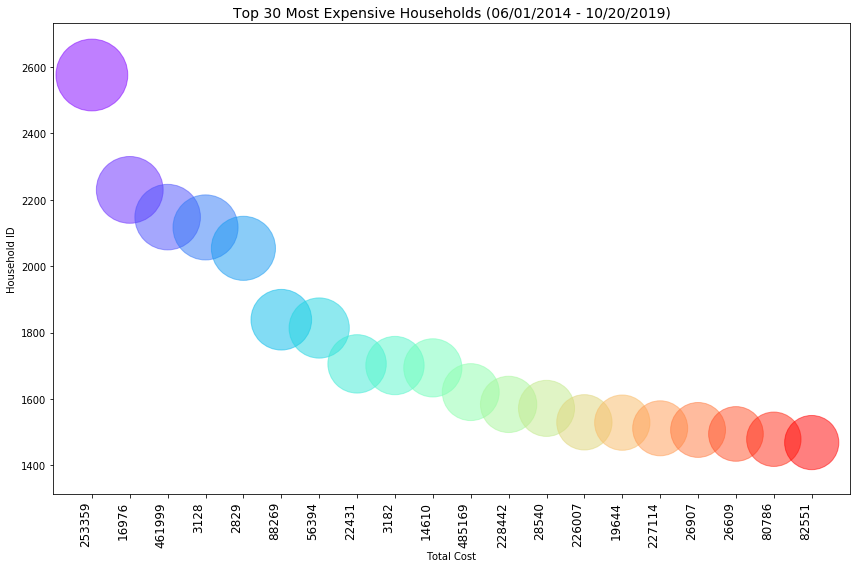

In [75]:
# Graph Time series per household
df_ts = pd.DataFrame(df_transaction, columns=['membership_id','call_status_recv_date',var_to_predict[0], 'member_status'])
min_date = df_ts['call_status_recv_date'].min().strftime("%m/%d/%Y") 
max_date = df_ts['call_status_recv_date'].max().strftime("%m/%d/%Y") 
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
t_membership_id = pd.DataFrame(df_ts.groupby(by=["membership_id"],
    axis=0,
    as_index=False,
    sort=True,
    group_keys=True,
    squeeze=True,
    observed=False).sum(), columns=['membership_id',var_to_predict[0]])

t_membership_id['pct'] = round(t_membership_id[var_to_predict]/t_membership_id[var_to_predict].sum()*100,2)
top_members = t_membership_id.sort_values(by=var_to_predict, ascending=False).head(20)
top_members['membership_id'] = top_members['membership_id'].astype(str)
top_members[var_to_predict] = top_members[var_to_predict].astype(int)
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.membership_id, y=top_members[var_to_predict], 
            s=top_members[var_to_predict]*2, alpha=0.5, c=colors)
plt.xlabel("Total Cost")
plt.ylabel("Household ID")
plt.title("Top 30 Most Expensive Households ("+ min_date + " - " + max_date + ")", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.ylim(bottom - 100, top + 100)
plt.show()

In [76]:
fig = px.scatter(top_members, x='membership_id', y=var_to_predict[0], size=var_to_predict[0], 
                 color=top_members['membership_id'],size_max=60,text=var_to_predict[0],
                 title = "Top 30 Most Expensive Households ("+ min_date + " - " + max_date + ")",
                )
fig.show()

In [77]:
# Line chart
df_ts = pd.DataFrame(df_transaction, columns=['membership_id','call_status_recv_date',var_to_predict[0], 'member_status'])
min_date = df_ts['call_status_recv_date'].min().strftime("%m/%d/%Y") 
max_date = df_ts['call_status_recv_date'].max().strftime("%m/%d/%Y") 
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts.set_index('call_status_recv_date', inplace=True)
df_ts_1 = df_ts.resample('W').sum()
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_ts_1.index, y=df_ts_1[var_to_predict[0]],
                        text=df_ts_1[var_to_predict], 
                        mode='lines+markers',
                        name='Total Costs'))
fig.update_layout(autosize=False, title_text='Time Series Analysis by Week - Total Costs',
                      xaxis_rangeslider_visible=True, height=700, width=900)
fig.show()

In [78]:
# Line chart
df_ts = pd.DataFrame(df_transaction, columns=['membership_id','call_status_recv_date',var_to_predict[0], 'member_status'])
min_date = df_ts['call_status_recv_date'].min().strftime("%m/%d/%Y") 
max_date = df_ts['call_status_recv_date'].max().strftime("%m/%d/%Y") 
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts.set_index('call_status_recv_date', inplace=True)
df_ts_1 = df_ts.resample('M').sum()
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_ts_1.index, y=df_ts_1[var_to_predict[0]],
                        text=df_ts_1[var_to_predict], 
                        mode='lines+markers',
                        name='Total Costs'))
fig.update_layout(autosize=False, title_text='Time Series Analysis by Month - Total Costs',
                      xaxis_rangeslider_visible=True, height=700, width=900)
fig.show()

In [79]:
# Line chart
df_ts = pd.DataFrame(df_transaction, columns=['membership_id','call_status_recv_date',var_to_predict[0], 'member_status'])
min_date = df_ts['call_status_recv_date'].min().strftime("%m/%d/%Y") 
max_date = df_ts['call_status_recv_date'].max().strftime("%m/%d/%Y") 
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts.set_index('call_status_recv_date', inplace=True)
df_ts_1 = df_ts.resample('Y').sum()
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_ts_1.index, y=df_ts_1[var_to_predict[0]],
                        text=df_ts_1[var_to_predict], 
                        mode='lines+markers',
                        name='Total Costs'))
fig.update_layout(autosize=False, title_text='Time Series Analysis by Month - Total Costs',
                      xaxis_rangeslider_visible=True, height=700, width=900)
fig.show()

# Reload data to conduct another experiment

In [80]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2961 entries, 0 to 5260
Data columns (total 87 columns):
membership_id                        int64
household_key                        int64
income                               object
member_status                        object
state_grouped                        object
credit_ranges                        object
cancel_reason                        object
renew_method                         object
plus_indicator_description           object
zip                                  int64
sc_vehicle_manufacturer_name         object
sc_vehicle_model_name                object
race                                 object
home_owner                           object
education                            object
dwelling_type                        object
gender                               object
occupation_code                      object
occupation_group                     object
occupant_type                        object
mosaic_household

# Original Numeric Columns
col_num =['aaa_member_tenure_years','aaa_mean_age','length_of_residence','aaa_mortgage','aaa_credit_card','aaa_deposit',
          'aaa_home_equity', 'aaa_financial_service','aaa_auto_insurance','aaa_id_theft','aaa_motorcycle_indicator',
          'aaa_travel','aaa_mean_child','aaa_no_race','aaa_no_home_owner','aaa_no_education','aaa_no_income',
          'aaa_no_dwelling_type','aaa_no_credit_ranges','aaa_no_gender','aaa_no_language','aaa_no_reason_joined',
          'aaa_no_mosaic_household','aaa_no_mosaic_global_household', 'aaa_no_kcl_b_ind_mosaicsgrouping',
          'aaa_no_occupation_code','aaa_no_occupation_group','aaa_no_occupant_type','aaa_no_plus_indicator_description',
          'aaa_no_generation','total_member_cost_1','total_member_cost_2','total_member_cost_3','basic_cost','plus_cost',
          'premier_cost','total_calls','total_member_cost','mean_total_member_cost','total_tow_miles','mean_tow_miles',
          'total_members_in_household','total_calls_veh','total_cost_veh','total_member_cost_veh','mean_total_calls_veh',
          'mean_total_cost_veh','mean_total_member_cost_veh','consumer_score','use_road_side'
         ]

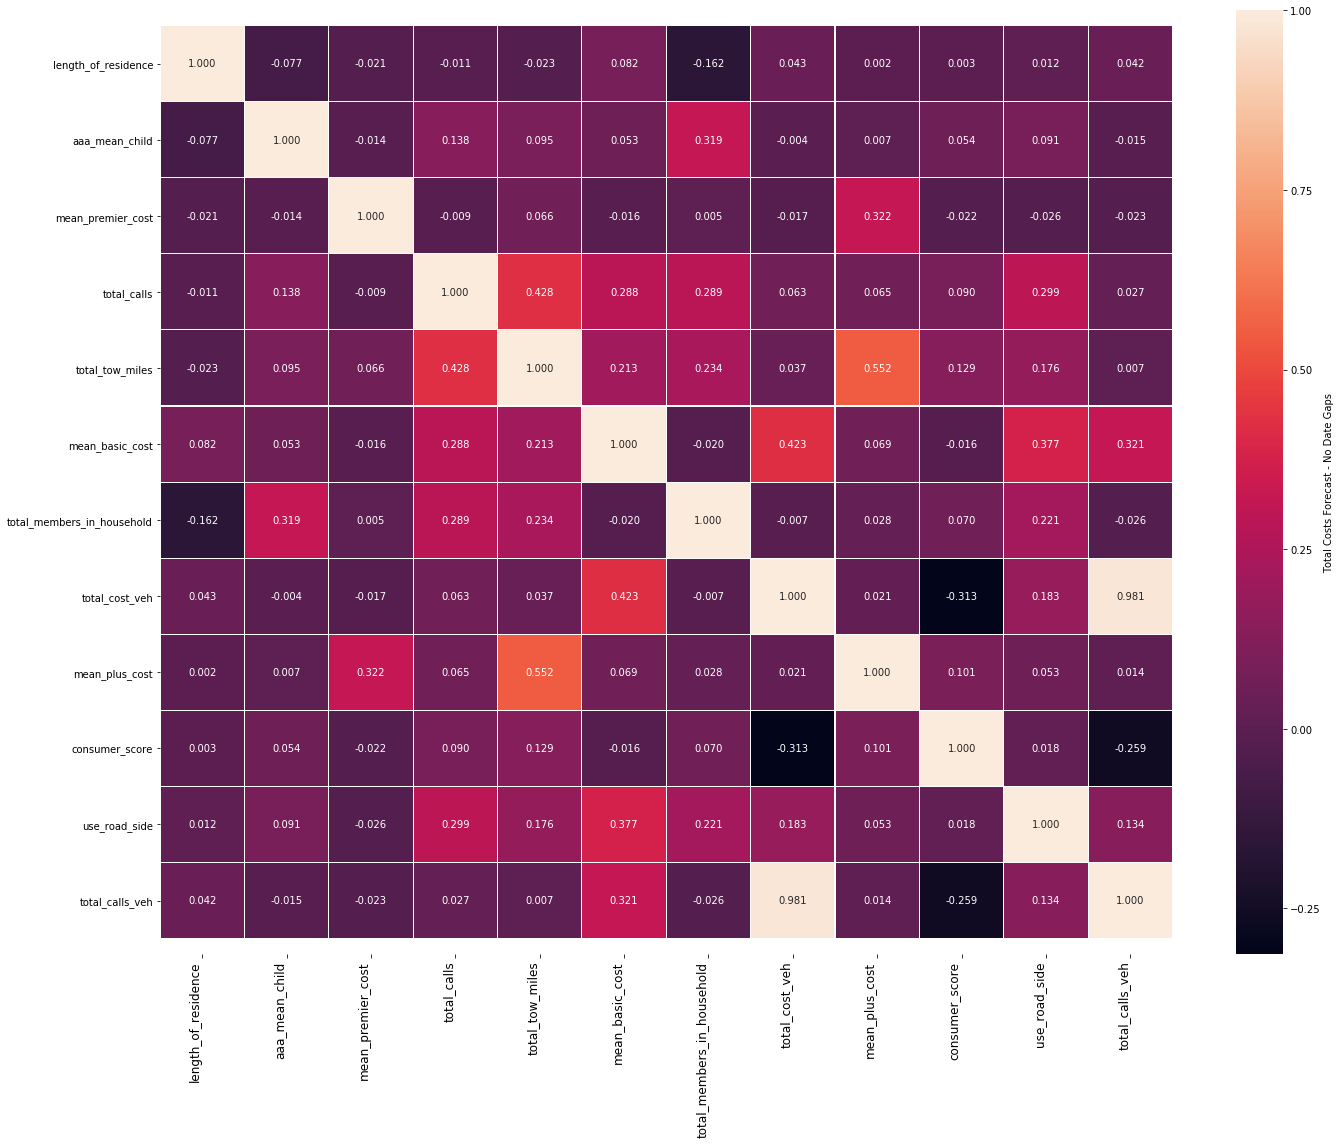

In [81]:
# Select all numeric features from df_household
# Get only numeric columns
# col_num = df_household.select_dtypes(include=np.number).columns.tolist()
# Removed: basic_costs, plus_cost, total_member_cost, total_cost_veh - All highly correlated so decided to remove them
col_num =['length_of_residence','aaa_mean_child',
          'mean_premier_cost','total_calls','total_tow_miles','mean_basic_cost',
          'total_members_in_household', 'total_cost_veh','mean_plus_cost',
          'consumer_score','use_road_side', 'total_calls_veh',
         ]
df_corr = pd.DataFrame(df_household, columns=col_num)
df_corr = df_corr.corr()
plt.figure(figsize=(20,16))
sns.heatmap(df_corr, annot=True, fmt=".3f", linewidths=0.1, xticklabels=True, 
                cbar_kws={'label': var_to_predict_title}, yticklabels=True)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.7, top - 0.7)
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
plt.savefig(var_to_predict_save+'_var_corr')
plt.show()

In [82]:
df_corr

length_of_residence  aaa_mean_child  mean_premier_cost  total_calls  total_tow_miles  mean_basic_cost  total_members_in_household  total_cost_veh  mean_plus_cost  consumer_score  use_road_side  total_calls_veh
length_of_residence                      1.0000         -0.0767            -0.0213      -0.0109          -0.0228           0.0824                     -0.1625          0.0432          0.0021          0.0034         0.0124           0.0424
aaa_mean_child                          -0.0767          1.0000            -0.0142       0.1376           0.0945           0.0529                      0.3194         -0.0045          0.0073          0.0543         0.0907          -0.0152
mean_premier_cost                       -0.0213         -0.0142             1.0000      -0.0088           0.0662          -0.0157                      0.0052         -0.0169          0.3225         -0.0221        -0.0258          -0.0226
total_calls                             -0.0109          0.1376            -0.0088       1.0000           0.4283           0.2878                      0.2891          0.0632          0.0651          0.0899         0.2993           0.0267
total_tow_miles                         -0.0228          0.0945             0.0662       0.4283           1.0000           0.2132                      0.2340          0.0372          0.5516          0.1293         0.1764           0.0075
mean_basic_cost                          0.0824          0.0529            -0.0157       0.2878           0.2132           1.0000                     -0.0203          0.4231          0.0692         -0.0160         0.3775           0.3213
total_members_in_household              -0.1625          0.3194             0.0052       0.2891           0.2340          -0.0203                      1.0000         -0.0071          0.0276          0.0695         0.2209          -0.0260
total_cost_veh                           0.0432         -0.0045            -0.0169       0.0632           0.0372           0.4231                     -0.0071          1.0000          0.0207         -0.3134         0.1827           0.9813
mean_plus_cost                           0.0021          0.0073             0.3225       0.0651           0.5516           0.0692                      0.0276          0.0207          1.0000          0.1012         0.0533           0.0136
consumer_score                           0.0034          0.0543            -0.0221       0.0899           0.1293          -0.0160                      0.0695         -0.3134          0.1012          1.0000         0.0177          -0.2586
use_road_side                            0.0124          0.0907            -0.0258       0.2993           0.1764           0.3775                      0.2209          0.1827          0.0533          0.0177         1.0000           0.1343
total_calls_veh                          0.0424         -0.0152            -0.0226       0.0267           0.0075           0.3213                     -0.0260          0.9813          0.0136         -0.2586         0.1343           1.0000

In [83]:
# Reload data to conduct another experiment
df_household = reiniciar(df_household)
cols_house_dummmies = ['aaa_financial_service','plus_indicator_description', 'aaa_id_theft', 'generation',
                       'occupation_group','sc_vehicle_manufacturer_name', 'tenure', 'aaa_auto_insurance',
                       'no_members', 'gender', 'kcl_b_ind_mosaicsgrouping','education','home_owner',
                       'aaa_motorcycle_indicator'
                      ]
# Get features from previous heatmap
feature_cols = col_num.copy()

# Build Dummies Variables
df_dummies = pd.get_dummies(df_household, columns=cols_house_dummmies)
for i in cols_house_dummmies:
    cols = [j for j in df_dummies.columns if j.startswith(i)]
    feature_cols += cols

# construct Dataframe for prediction
feature_cols += var_to_predict
df_prediction = pd.DataFrame(df_dummies, columns=feature_cols)

# Stripping out spaces from ends of names, and replacing internal spaces with "_"
df_prediction.columns = [col.strip().replace(' ', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('&', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('+', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace(',', '').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('(', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace(')', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('<', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('.', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('/', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('-', '_').lower() for col in df_prediction.columns]

# Fix Nans
# Number of child
df_prediction.aaa_mean_child.fillna(value=0, inplace=True)
df_prediction.consumer_score.fillna(value=0, inplace=True)
# Drop Unknown Columns 
cols_to_drop = [j for j in df_prediction.columns if j.endswith('unknown')]
df_prediction.drop(labels=cols_to_drop,axis=1, inplace=True)

# Save columns name for future use in modelling to split X-Input and y-Output
X_cols = df_prediction.columns[:-1]
y_cols = var_to_predict.copy()

df_prediction.head(5)

length_of_residence  aaa_mean_child  mean_premier_cost  total_calls  total_tow_miles  mean_basic_cost  total_members_in_household  total_cost_veh  mean_plus_cost  consumer_score  use_road_side  total_calls_veh  aaa_financial_service_0  aaa_financial_service_1  plus_indicator_description_basic_membership  plus_indicator_description_plus_membership  plus_indicator_description_plus_membership_with_motorcycle_coverage  plus_indicator_description_premier_membership  aaa_id_theft_0  aaa_id_theft_1  generation_baby_boomers__1948___1968_  generation_generation_x__1969___1980_  generation_generation_z__1994___2010_  generation_millenials__1981___1993_  generation_post_war____1948_  occupation_group_management  occupation_group_other  occupation_group_professional  occupation_group_retired  sc_vehicle_manufacturer_name_american_austin  sc_vehicle_manufacturer_name_luxury_vehicle  sc_vehicle_manufacturer_name_middle_end_vehicle  sc_vehicle_manufacturer_name_standard_end_vehicle  \
0              15.0000          2.0000             0.0000      24.0000           0.8000          34.7917                           1     142122.6600          0.0000          0.0137              1        7477.0000                        1                        0                                            1                                           0                                                  0                                                                0               1               0                                      0                                      0                                      0                                    0                             1                            0                       0                              0                         0                                             0                                            0                                                0                                                  1   
2               8.6364          1.0000             0.0000      12.0000           0.0000          39.5318                           4      29447.1100          0.0000          0.0123              1        1384.0000                        1                        0                                            1                                           0                                                  0                                                                0               1               0                                      0                                      0                                      0                                    1                             0                            0                       0                              0                         0                                             0                                            0                                                0                                                  1   
3              15.0000          1.0000             0.0000       0.0000           0.0000          28.0000                           1       5980.6000          0.0000          0.0143              0         466.0000                        1                        0                                            1                                           0                                                  0                                                                0               1               0                                      0                                      0                                      0                                    0                             1                            0                       0                              0                         1                                             0                                            1                                                0                                                  0   
4              15.0000          2.0000             

In [84]:
df_prediction.describe()

length_of_residence  aaa_mean_child  mean_premier_cost  total_calls  total_tow_miles  mean_basic_cost  total_members_in_household  total_cost_veh  mean_plus_cost  consumer_score  use_road_side  total_calls_veh  aaa_financial_service_0  aaa_financial_service_1  plus_indicator_description_basic_membership  plus_indicator_description_plus_membership  plus_indicator_description_plus_membership_with_motorcycle_coverage  plus_indicator_description_premier_membership  aaa_id_theft_0  aaa_id_theft_1  generation_baby_boomers__1948___1968_  generation_generation_x__1969___1980_  generation_generation_z__1994___2010_  generation_millenials__1981___1993_  generation_post_war____1948_  occupation_group_management  occupation_group_other  occupation_group_professional  occupation_group_retired  sc_vehicle_manufacturer_name_american_austin  sc_vehicle_manufacturer_name_luxury_vehicle  sc_vehicle_manufacturer_name_middle_end_vehicle  sc_vehicle_manufacturer_name_standard_end_vehicle  \
count            2961.0000       2961.0000          2961.0000    2961.0000        2961.0000        2961.0000                   2961.0000       2961.0000       2961.0000       2961.0000      2961.0000        2961.0000                2961.0000                2961.0000                                    2961.0000                                   2961.0000                                          2961.0000                                                        2961.0000       2961.0000       2961.0000                              2961.0000                              2961.0000                              2961.0000                            2961.0000                     2961.0000                    2961.0000               2961.0000                      2961.0000                 2961.0000                                     2961.0000                                    2961.0000                                        2961.0000                                          2961.0000   
mean                8.1485          1.4692             0.0105      12.4140          11.5416          27.5414                      2.4802      46069.9786          1.9517          0.0097         0.6957        2909.1280                   0.9092                   0.0908                                       0.4043                                      0.2925                                             0.0007                                                           0.0233          0.9362          0.0638                                 0.2712                                 0.0500                                 0.0030                               0.0392                        0.6180                       0.1084                  0.0331                         0.1763                    0.2509                                        0.0003                                       0.0993                                           0.0493                                             0.5711   
std                 5.7365          1.0721             0.4996      27.4340          29.5176          17.9677                      1.3217      49638.7038          8.8672          0.0072         0.4602        2402.2905                   0.2874                   0.2874                                       0.4908                                      0.4550                                             0.0260                                                           0.1509          0.2445          0.2445                                 0.4447                                 0.2179                                 0.0551                               0.1940                        0.4860                       0.3109                  0.1789                         0.3811                    0.4336                                        0.0184                                       0.2991                                           0.2165                                             0.4950   
min                 0.0000          0.0

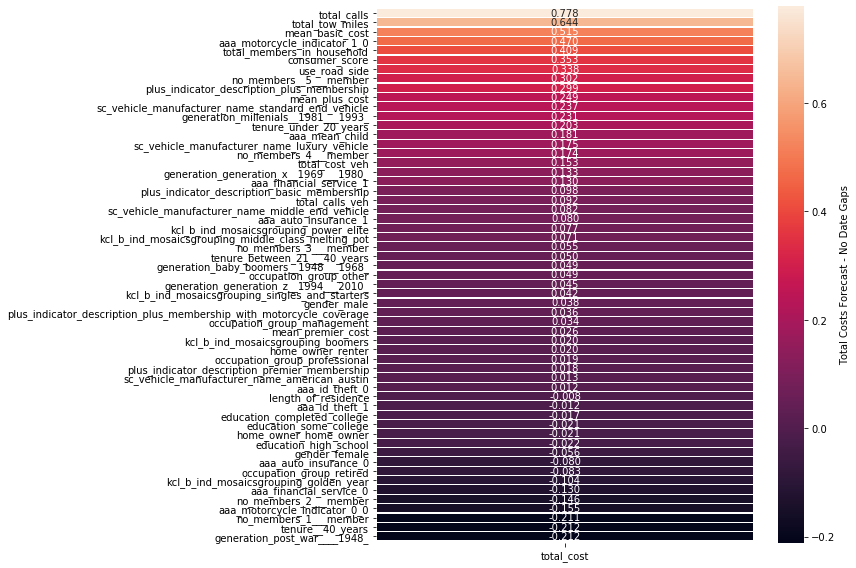

In [85]:
#  Correlation of AAA Costs and other numeric features
# Heat Map 
df_corr = df_prediction.corr()
df_corr.sort_values(by=var_to_predict[0], ascending=False, inplace=True)
df_corr = df_corr[df_corr.index.values!=var_to_predict[0]]
sns.heatmap(df_corr[[var_to_predict[0]]], annot=True, fmt=".3f", linewidths=0.1, xticklabels=True, 
                cbar_kws={'label': var_to_predict_title}, yticklabels=True)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.7, top - 0.7)
plt.savefig(var_to_predict_save+'_var_corr_tot_cost')
plt.show()
#df_corr

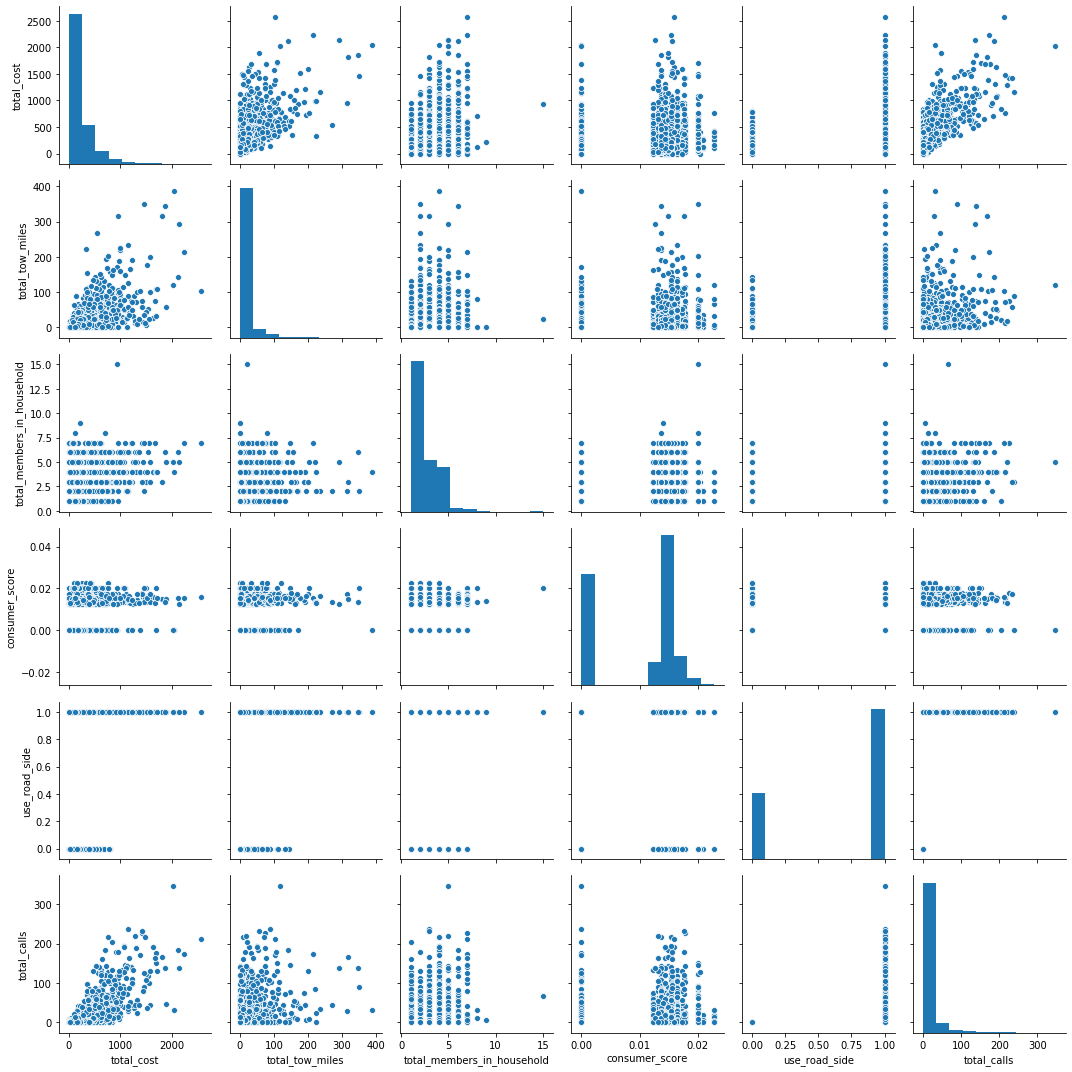

In [86]:
# Pair plot 
sns.pairplot(df_prediction[[var_to_predict[0], 'total_tow_miles', 'total_members_in_household', 
                            'consumer_score','use_road_side', 'total_calls']])
plt.show()

In [87]:
# Reset figure and display settings
%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})

# Setting Up the Training and Test data for up Sampling the minority class
To use the same split in all models

# Algorithms Search and Testing

In [ ]:
from sklearn.utils.testing import all_estimators
from sklearn import base
from sklearn.metrics import SCORERS


estimators = all_estimators()
for name, class_ in estimators:
    if issubclass(class_, base.RegressorMixin):
        print(name)

SCORERS.keys()

In [88]:
num_folds = 10
np.random.seed(42)
scoring = 'neg_mean_squared_error'
test_size = 0.30

# Create input and output dataframes

X_df = pd.DataFrame(df_prediction,columns=X_cols)
y_df = pd.DataFrame(df_prediction,columns=y_cols)

# Transform / Normalize the data
scaler_x = PowerTransformer()
scaled_df_x = scaler_x.fit_transform(X_df)
scaled_df_x = pd.DataFrame(scaled_df_x, columns=X_df.columns)

scaler_y = PowerTransformer()
scaled_df_y = scaler_y.fit_transform(y_df)
scaled_df_y = pd.DataFrame(scaled_df_y, columns=y_df.columns)


# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_x, scaled_df_y, test_size=test_size)

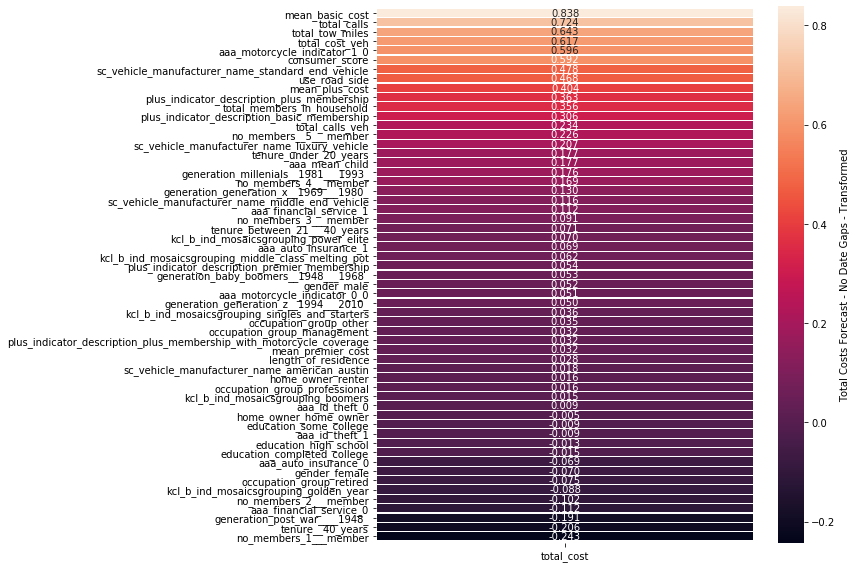

In [89]:
#  Correlation of AAA Costs and other numeric features
# Heat Map 
df_corr = scaled_df_x.copy()
df_corr[var_to_predict] = scaled_df_y[var_to_predict]
df_corr = df_corr.corr()
df_corr.sort_values(by=var_to_predict[0], ascending=False, inplace=True)
df_corr = df_corr[df_corr.index.values!=var_to_predict[0]]
sns.heatmap(df_corr[[var_to_predict[0]]], annot=True, fmt=".3f", linewidths=0.1, xticklabels=True, 
                cbar_kws={'label': var_to_predict_title+' - Transformed'}, yticklabels=True)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.7, top - 0.7)
plt.savefig(var_to_predict_save+'_var_corr_tot_cost_transf')
plt.show()
#df_corr

Total Costs Forecast - No Date Gaps - Algorithm Comparison - Regression
BR: RMSE : -0.078 - Std. Dev.: (0.010)
DTR: RMSE : -0.091 - Std. Dev.: (0.007)
EN: RMSE : -0.615 - Std. Dev.: (0.056)
ENCV: RMSE : -0.077 - Std. Dev.: (0.010)
LASSO: RMSE : -0.992 - Std. Dev.: (0.091)
LASCV: RMSE : -0.077 - Std. Dev.: (0.010)
LSVR: RMSE : -0.084 - Std. Dev.: (0.011)
SGDR: RMSE : -3.667 - Std. Dev.: (7.292)
KNNR: RMSE : -0.273 - Std. Dev.: (0.039)
RIDGE: RMSE : -0.077 - Std. Dev.: (0.010)
RIDCV: RMSE : -0.077 - Std. Dev.: (0.010)
ABR: RMSE : -0.078 - Std. Dev.: (0.007)
GBR: RMSE : -0.042 - Std. Dev.: (0.006)
RFR: RMSE : -0.053 - Std. Dev.: (0.007)
ET: RMSE : -0.059 - Std. Dev.: (0.009)
XGB: RMSE : -0.042 - Std. Dev.: (0.006)
BGR: RMSE : -0.052 - Std. Dev.: (0.006)


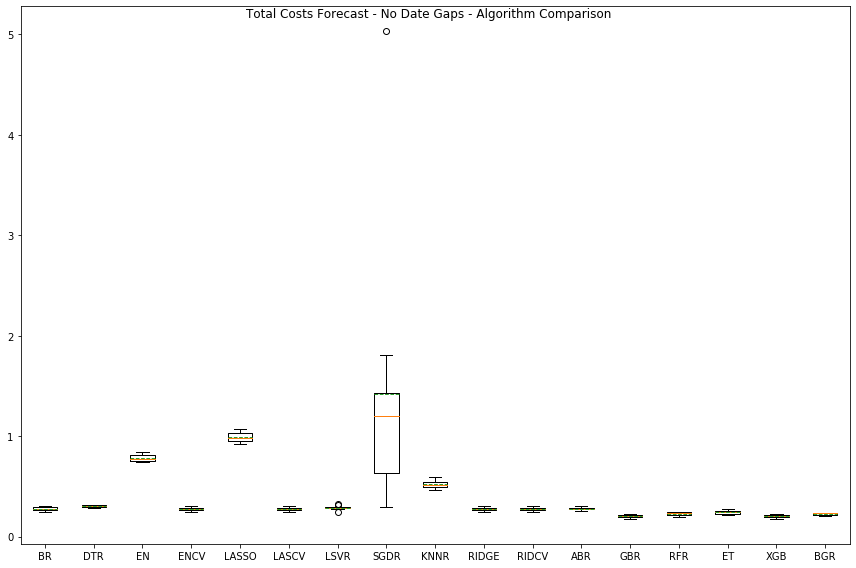

In [90]:
# Algorithms Search
# Spot Check Algorithms

# Linear Regression Methods
print(var_to_predict_title+' - Algorithm Comparison - Regression')
models = []
#models.append(('OLS', LinearRegression(normalize=False)))
models.append(('BR', BayesianRidge(normalize=False)))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('EN', ElasticNet(normalize=False)))
models.append(('ENCV', ElasticNetCV(normalize=False)))
models.append(('LASSO', Lasso(normalize=False)))
models.append(('LASCV', LassoCV(normalize=False)))
models.append(('LSVR', LinearSVR()))
models.append(('SGDR', SGDRegressor()))
models.append(('KNNR', KNeighborsRegressor()))
models.append(('RIDGE', Ridge(normalize=False)))
models.append(('RIDCV', RidgeCV(normalize=False)))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    # Calculate RMSE
    results.append(np.sqrt(np.abs(cv_results)))
    names.append(name)                          
    msg = "%s: RMSE : %.3f - Std. Dev.: (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Ensembles Methods
ensembles = []
ensembles.append(('ABR', AdaBoostRegressor()))
ensembles.append(('GBR', GradientBoostingRegressor()))
ensembles.append(('RFR', RandomForestRegressor(n_estimators=10)))
ensembles.append(('ET', ExtraTreesRegressor(n_estimators=10)))
ensembles.append(('XGB', XGBRegressor(silent=True)))
ensembles.append(('BGR', BaggingRegressor()))

for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(np.sqrt(np.abs(cv_results)))
    names.append(name)
    msg = "%s: RMSE : %.3f - Std. Dev.: (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle(var_to_predict_title+' - Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results, meanline=True, showmeans=True)
ax.set_xticklabels(names)
plt.savefig(var_to_predict_save+'_algorithms')
plt.show()

# Observation

R^2 (coefficient of determination) regression score function.

    * Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that
    always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

mean_squared_error
    * A non-negative floating point value (the best value is 0.0)
    The MSE is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better.

Based on the graph above (RMSE):
    * 1) XGB: RMSE : -0.042 - Std. Dev.: (0.006)
    * 2) GBR: RMSE : -0.042 - Std. Dev.: (0.006)
    * 3) BGR: RMSE : -0.052 - Std. Dev.: (0.006)
    * 4) RFR: RMSE : -0.053 - Std. Dev.: (0.007)
    * 5) ET: RMSE  : -0.059 - Std. Dev.: (0.009)

# Grid Search XGB Regressor

In [98]:
# Grid Search XGBOOST regression
np.random.seed(42)
xgbr_param_grid = {'colsample_bytree': [0.3, 0.7],'n_estimators': [100, 250, 500, 1000],
                  'max_depth': [3,4,5,6], 'learning_rate': [0.1, 0.01, 0.05, 1],
                   'booster': ['gbtree'], 'gamma': [0, 0.1]
                 }
kfold = KFold(n_splits=num_folds)
xgbr = XGBRegressor(silent=True)
# Perform grid search: grid_mse
xgbr_grid = GridSearchCV(estimator=xgbr, param_grid=xgbr_param_grid,
                       scoring=scoring, cv=kfold, verbose=1, n_jobs=10)
xgbr_grid.fit(trainX, trainy)
# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgbr_grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(xgbr_grid.best_score_)))
            

Fitting 10 folds for each of 256 candidates, totalling 2560 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   23.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  4.7min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  8.4min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 13.4min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 22.3min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 32.4min
[Parallel(n_jobs=10)]: Done 2560 out of 2560 | elapsed: 34.8min finished


Best parameters found:  {'booster': 'gbtree', 'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
Lowest RMSE found:  0.20064251564638336


# Observation
These are the best parameters:

First run identifying C
    * Best parameters found:  {'booster': 'gbtree', 'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 
    * 'n_estimators': 1000}
    * Lowest RMSE found:  0.20064251564638336

In [99]:
# Modeling based on the outcome of the grid serach of the random forest
xgbr = XGBRegressor(silent=True, booster='gbtree', colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=1000, 
                   gamma=0)

xgbr.fit(trainX, trainy)

# Predict on test set
yhat_train = xgbr.predict(trainX)

# Predict on test set
yhat = xgbr.predict(testX)

# Calculate Cross valdation scores
scores_xgbr = cross_val_score(xgbr, testX, testy, cv=num_folds, scoring=scoring)

print('XGBoost Classifer Train r2 score - Transformed : %.5f' % r2_score(trainy, yhat_train))
print('XGBoost Classifer Test r2 score - Transformed  : %.5f' % r2_score(testy, yhat))
yhat_train_mse1 = mean_squared_error(trainy, yhat_train)
yhat_test_mse1 = mean_squared_error(testy, yhat)
yhat_train_rmse1 = np.sqrt(yhat_train_mse1)
yhat_test_rmse1 = np.sqrt(yhat_test_mse1)
print('XGBoost Classifer  Train MSE - Transformed    : %.5f' % yhat_train_mse1)
print('XGBoost Classifer  Test MSE - Transformed     : %.5f' % yhat_test_mse1)
print('XGBoost Classifer  Train RMSE - Transformed   : %.5f' % yhat_train_rmse1)
print('XGBoost Classifer  Test RMSE - Transformed    : %.5f' % yhat_test_rmse1)

# Plot Cross Validation RMSE Scores
fig = px.line(np.sqrt(np.abs(scores_xgbr)), y=np.sqrt(np.abs(scores_xgbr)), labels={'y':'RMSE'}, title=var_to_predict_title+ ' - RMSE Cross Validation Scores - Transformed')
fig.write_image(var_to_predict_save+'_xgbr_crossv.png')
fig.show()

XGBoost Classifer Train r2 score - Transformed : 0.97620
XGBoost Classifer Test r2 score - Transformed  : 0.96329
XGBoost Classifer  Train MSE - Transformed    : 0.02356
XGBoost Classifer  Test MSE - Transformed     : 0.03753
XGBoost Classifer  Train RMSE - Transformed   : 0.15350
XGBoost Classifer  Test RMSE - Transformed    : 0.19373


In [100]:
# Untransformed series
un_trainy = trainy.copy()
un_trainy[var_to_predict] = scaler_y.inverse_transform(un_trainy) 

un_testy = testy.copy()
un_testy[var_to_predict] = scaler_y.inverse_transform(un_testy) 

un_yhat_train = pd.DataFrame(data=scaler_y.inverse_transform(yhat_train.reshape(-1, 1)), 
                                  index=trainy.index, columns=var_to_predict) 

un_yhat = pd.DataFrame(data=scaler_y.inverse_transform(yhat.reshape(-1, 1)), 
                                  index=testy.index, columns=var_to_predict) 

# Build Training Dataframe
df_train = un_trainy.copy()
df_train['FCST Total Cost Train'] = un_yhat_train[var_to_predict]
df_train['FCST Error Train'] = un_yhat_train[var_to_predict]
df_train['FCST Error Train'] -= df_train['FCST Total Cost Train']

# Build test dataframe
df_test = un_testy.copy()
df_test['FCST Total Cost Test'] = un_yhat[var_to_predict]
df_test['FCST Error Test'] = df_test[var_to_predict]
df_test['FCST Error Test'] -= df_test['FCST Total Cost Test']

print('XGBoost Regressor Train r2 score : %.5f' % r2_score(un_trainy, un_yhat_train))
print('XGBoost Regressor Test  r2 score : %.5f' % r2_score(un_testy, un_yhat))
un_yhat_train_mse1 = mean_squared_error(un_trainy, un_yhat_train)
un_yhat_test_mse1 = mean_squared_error(un_testy, un_yhat)
un_yhat_train_rmse1 = np.sqrt(un_yhat_train_mse1)
un_yhat_test_rmse1 = np.sqrt(un_yhat_test_mse1)
print('XGBoost Regressor  Train MSE             : %.5f' % un_yhat_train_mse1)
print('XGBoost Regressor  Test MSE              : %.5f' % un_yhat_test_mse1)
print('XGBoost Regressor  Train RMSE            : %.5f' % un_yhat_train_rmse1)
print('XGBoost Regressor  Test RMSE             : %.5f' % un_yhat_test_rmse1)
print('XGBoost Regressor  Train Mean FCST Error : %.5f' % df_train['FCST Error Train'].mean())
print('XGBoost Regressor  Test Mean FCST Error  : %.5f' % df_test['FCST Error Test'].mean())


XGBoost Regressor Train r2 score : 0.94467
XGBoost Regressor Test  r2 score : 0.87739
XGBoost Regressor  Train MSE             : 4107.34418
XGBoost Regressor  Test MSE              : 9975.79028
XGBoost Regressor  Train RMSE            : 64.08857
XGBoost Regressor  Test RMSE             : 99.87888
XGBoost Regressor  Train Mean FCST Error : 0.00000
XGBoost Regressor  Test Mean FCST Error  : 8.66180


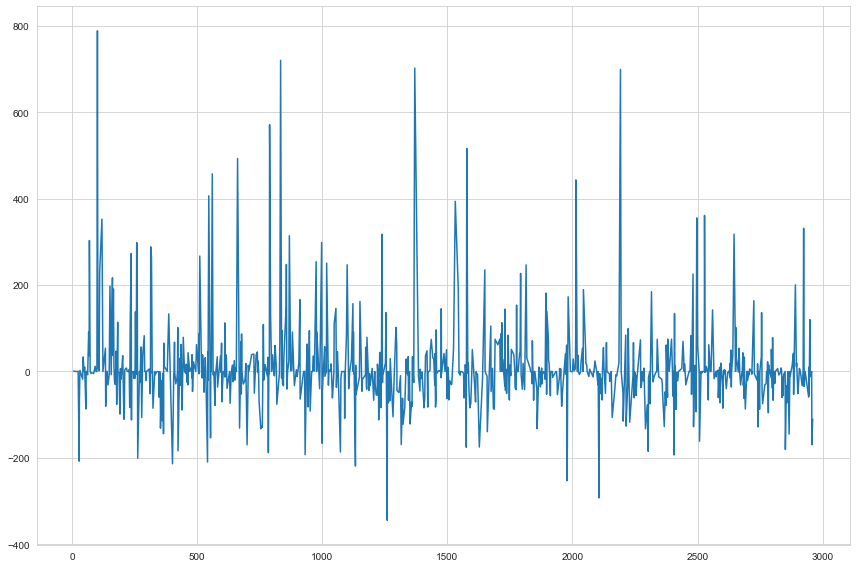

In [101]:
sns.lineplot(data=df_test['FCST Error Test'])
plt.show()

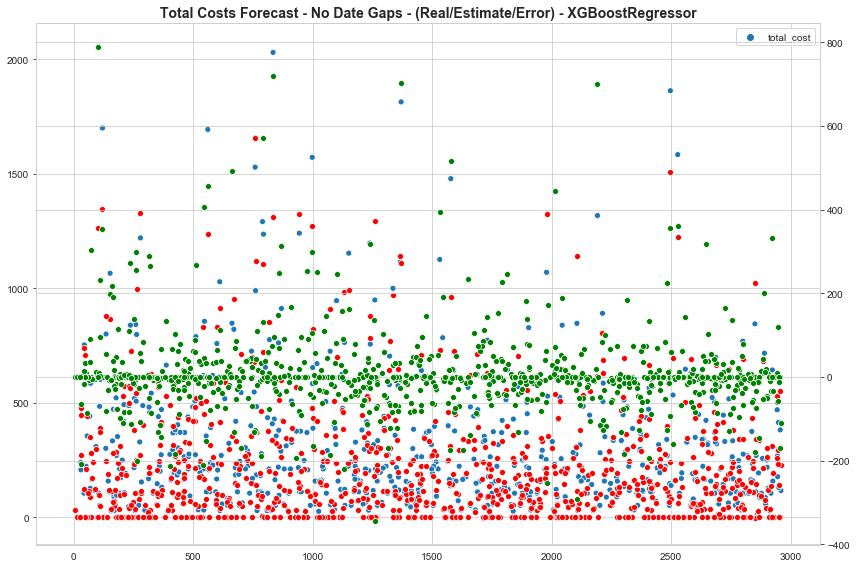

In [102]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.scatterplot(data=df_test[var_to_predict], color="b", legend='full', ax=ax1)
sns.scatterplot(data=df_test['FCST Total Cost Test'], color="r", legend='full', ax=ax1)
sns.scatterplot(data=df_test['FCST Error Test'], color="g", legend='full', ax=ax2)
plt.title(var_to_predict_title+ ' - (Real/Estimate/Error) - XGBoostRegressor',fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_scatter_xgbr')
plt.show()

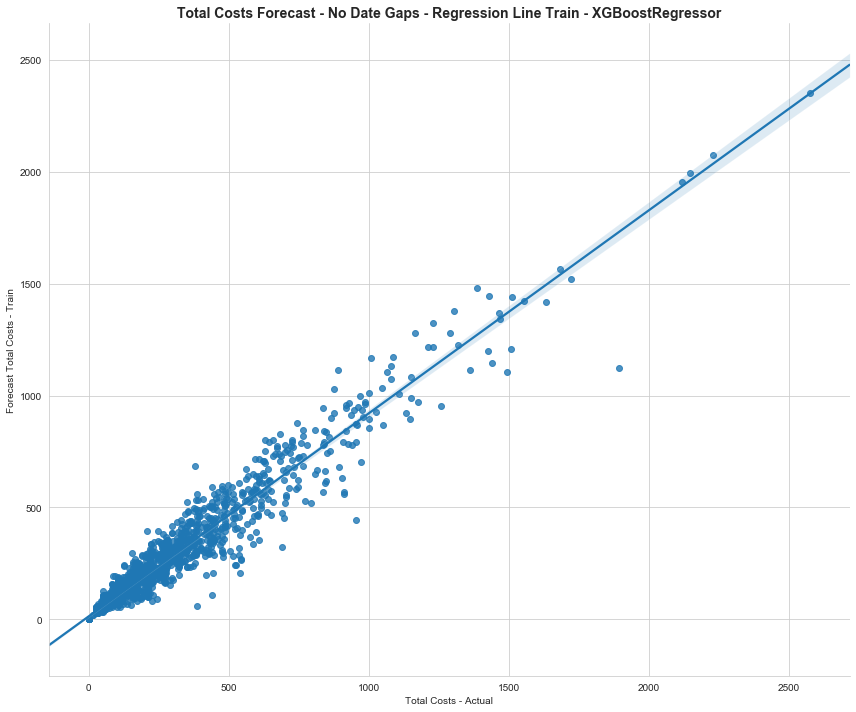

In [103]:
# Graph Train prediction
sns.set_style("whitegrid", {'axes.grid' : True})
g = sns.lmplot(x=var_to_predict[0], y='FCST Total Cost Train', data=df_train, height=10, aspect=1.2)
g.set_axis_labels("Total Costs - Actual", "Forecast Total Costs - Train") 
plt.title(var_to_predict_title+ ' - Regression Line Train - XGBoostRegressor',fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_fcst_train_xgbr')
plt.show()

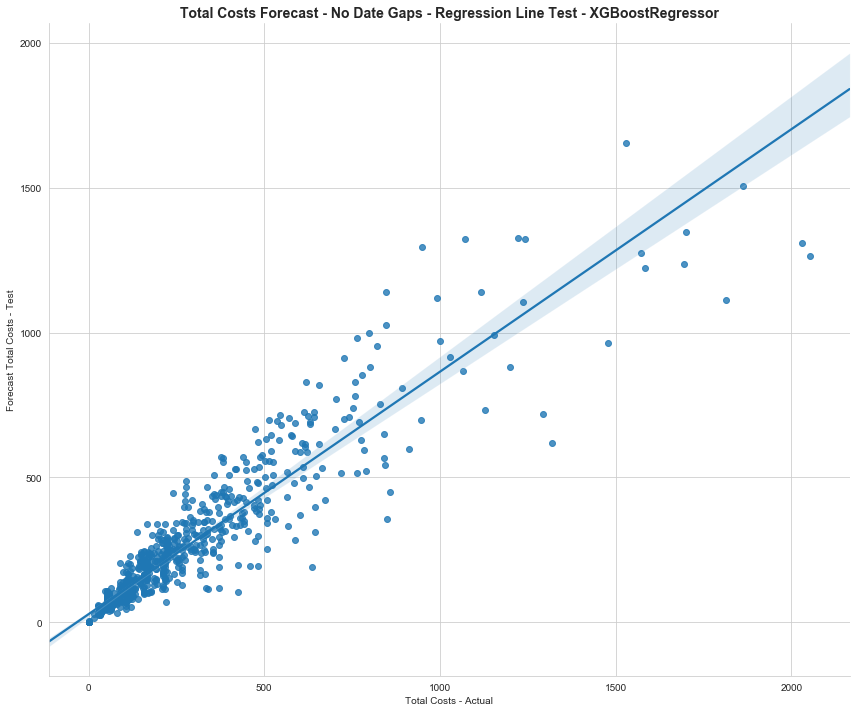

In [104]:
# Graph Test prediction
g = sns.lmplot(x=var_to_predict[0], y='FCST Total Cost Test', data=df_test, height=10, aspect=1.2)
g.set_axis_labels("Total Costs - Actual", "Forecast Total Costs - Test") 
plt.title(var_to_predict_title+ ' - Regression Line Test - XGBoostRegressor',fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_fcst_test_xgbr')
plt.show()

In [105]:
fig = px.line(un_yhat_train, y=var_to_predict[0], labels={var_to_predict[0]:var_to_predict_title}, title=var_to_predict_title+ ' - RMSE Cross Validation Scores - Transformed')
fig.show()

# Gradient Boosting Regression Grid Search

In [106]:
# Grid Search - Gradient Boosting Regression
np.random.seed(42)
gbr_param_grid = {'n_estimators': [100, 250, 500, 750, 1000],
                  'max_depth': [3,4,5,6,7], 'learning_rate': [0.1, 0.01, 0.05,1],
                 }
kfold = KFold(n_splits=num_folds)
gbr = GradientBoostingRegressor()
# Perform grid search: grid_mse
gbr_grid = GridSearchCV(estimator=gbr, param_grid=gbr_param_grid,
                       scoring=scoring, cv=kfold, verbose=1, n_jobs=10)
gbr_grid.fit(trainX, trainy)
# Print the best parameters and lowest RMSE
print('Gradient boosting Regression - Grid Search')
print("Best parameters found: ", gbr_grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(gbr_grid.best_score_)))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   28.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  9.3min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 18.1min
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed: 21.3min finished


Gradient boosting Regression - Grid Search
Best parameters found:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 750}
Lowest RMSE found:  0.2006731670520101


# Observation
These are the best parameters:

First run identifying parameters
    * Best parameters found:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 750}
    * Lowest RMSE found:  0.2006731670520101


In [107]:
# Modeling based on the outcome of the grid serach of Gradient Boosting 
gbr = GradientBoostingRegressor(verbose=0, learning_rate=0.05, max_depth=3, n_estimators=750)

gbr.fit(trainX, trainy)

# Predict on test set
yhat_train = gbr.predict(trainX)

# Predict on test set
yhat = gbr.predict(testX)

# Calculate Cross valdation scores
scores_gbr = cross_val_score(gbr, testX, testy, cv=num_folds, scoring=scoring)

print('Gradient Boost Regressor Train r2 score - Transformed : %.5f' % r2_score(trainy, yhat_train))
print('Gradient Boost Regressor Test r2 score - Transformed  : %.5f' % r2_score(testy, yhat))
yhat_train_mse1 = mean_squared_error(trainy, yhat_train)
yhat_test_mse1 = mean_squared_error(testy, yhat)
yhat_train_rmse1 = np.sqrt(yhat_train_mse1)
yhat_test_rmse1 = np.sqrt(yhat_test_mse1)
print('Gradient Boost Regressor  Train MSE - Transformed    : %.5f' % yhat_train_mse1)
print('Gradient Boost Regressor  Test MSE - Transformed     : %.5f' % yhat_test_mse1)
print('Gradient Boost Regressor Train RMSE - Transformed   : %.5f' % yhat_train_rmse1)
print('Gradient Boost Regressor Test RMSE - Transformed    : %.5f' % yhat_test_rmse1)

# Plot Cross Validation RMSE Scores
fig = px.line(np.sqrt(np.abs(scores_gbr)), y=np.sqrt(np.abs(scores_gbr)), labels={'y':'RMSE'}, title=var_to_predict_title+ ' - RMSE Cross Validation Scores - Transformed')
fig.write_image(var_to_predict_save+'_gbr_crossv.png')
fig.show()

Gradient Boost Regressor Train r2 score - Transformed : 0.98264
Gradient Boost Regressor Test r2 score - Transformed  : 0.96271
Gradient Boost Regressor  Train MSE - Transformed    : 0.01719
Gradient Boost Regressor  Test MSE - Transformed     : 0.03812
Gradient Boost Regressor Train RMSE - Transformed   : 0.13109
Gradient Boost Regressor Test RMSE - Transformed    : 0.19525


In [108]:
# Untransformed series
un_trainy = trainy.copy()
un_trainy[var_to_predict] = scaler_y.inverse_transform(un_trainy) 

un_testy = testy.copy()
un_testy[var_to_predict] = scaler_y.inverse_transform(un_testy) 

un_yhat_train = pd.DataFrame(data=scaler_y.inverse_transform(yhat_train.reshape(-1, 1)), 
                                  index=trainy.index, columns=var_to_predict) 

un_yhat = pd.DataFrame(data=scaler_y.inverse_transform(yhat.reshape(-1, 1)), 
                                  index=testy.index, columns=var_to_predict) 

# Build Training Dataframe
df_train = un_trainy.copy()
df_train['FCST Total Cost Train'] = un_yhat_train[var_to_predict]
df_train['FCST Error Train'] = un_yhat_train[var_to_predict]
df_train['FCST Error Train'] -= df_train['FCST Total Cost Train']

# Build test dataframe
df_test = un_testy.copy()
df_test['FCST Total Cost Test'] = un_yhat[var_to_predict]
df_test['FCST Error Test'] = df_test[var_to_predict]
df_test['FCST Error Test'] -= df_test['FCST Total Cost Test']

print('Gradient Boost Regressor Train r2 score : %.5f' % r2_score(un_trainy, un_yhat_train))
print('Gradient Boost Regressor Test  r2 score : %.5f' % r2_score(un_testy, un_yhat))
un_yhat_train_mse1 = mean_squared_error(un_trainy, un_yhat_train)
un_yhat_test_mse1 = mean_squared_error(un_testy, un_yhat)
un_yhat_train_rmse1 = np.sqrt(un_yhat_train_mse1)
un_yhat_test_rmse1 = np.sqrt(un_yhat_test_mse1)
print('Gradient Boost Regressor  Train MSE             : %.5f' % un_yhat_train_mse1)
print('Gradient Boost Regressor  Test MSE              : %.5f' % un_yhat_test_mse1)
print('Gradient Boost Regressor  Train RMSE            : %.5f' % un_yhat_train_rmse1)
print('Gradient Boost Regressor  Test RMSE             : %.5f' % un_yhat_test_rmse1)
print('Gradient Boost Regressor  Train Mean FCST Error : %.5f' % df_train['FCST Error Train'].mean())
print('Gradient Boost Regressor  Test Mean FCST Error  : %.5f' % df_test['FCST Error Test'].mean())


Gradient Boost Regressor Train r2 score : 0.96518
Gradient Boost Regressor Test  r2 score : 0.86731
Gradient Boost Regressor  Train MSE             : 2584.54360
Gradient Boost Regressor  Test MSE              : 10796.01441
Gradient Boost Regressor  Train RMSE            : 50.83841
Gradient Boost Regressor  Test RMSE             : 103.90387
Gradient Boost Regressor  Train Mean FCST Error : 0.00000
Gradient Boost Regressor  Test Mean FCST Error  : 3.01080


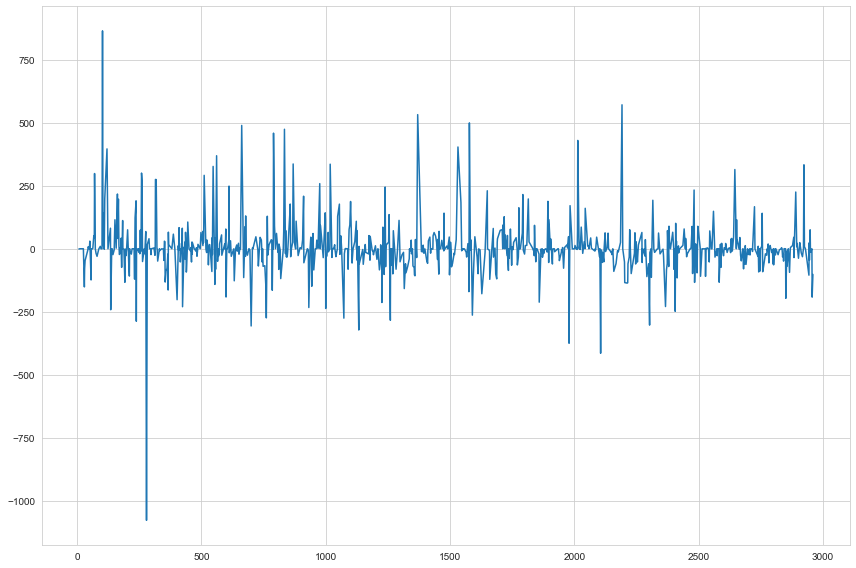

In [109]:
sns.lineplot(data=df_test['FCST Error Test'])
plt.show()

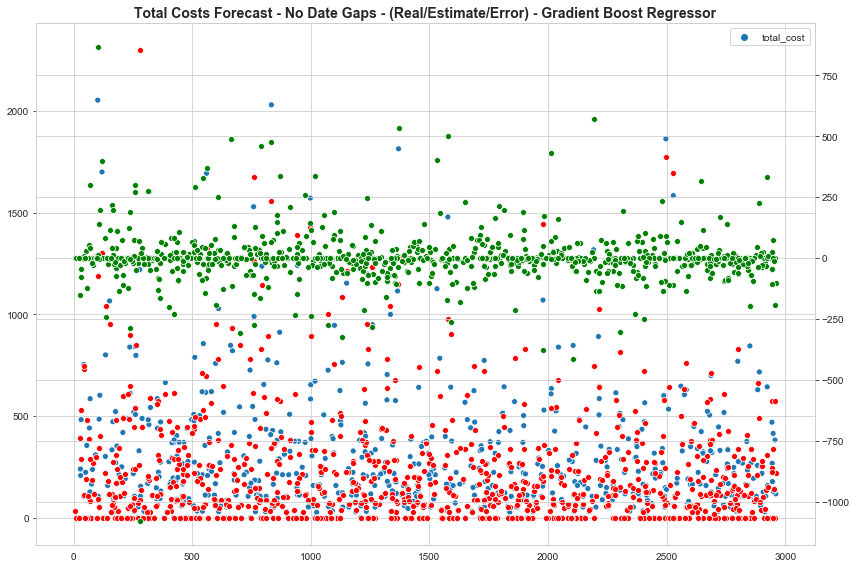

In [110]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.scatterplot(data=df_test[var_to_predict], color="b", legend='full', ax=ax1)
sns.scatterplot(data=df_test['FCST Total Cost Test'], color="r", legend='full', ax=ax1)
sns.scatterplot(data=df_test['FCST Error Test'], color="g", legend='full', ax=ax2)
plt.title(var_to_predict_title+ ' - (Real/Estimate/Error) - Gradient Boost Regressor',
          fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_scatter_gbr')
plt.show()

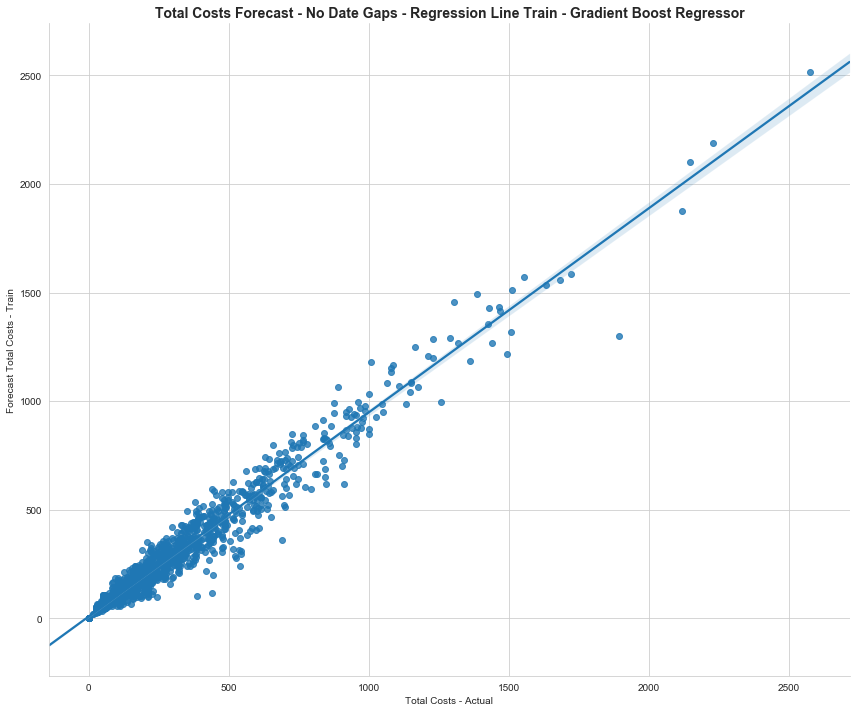

In [111]:
# Graph Train prediction
sns.set_style("whitegrid", {'axes.grid' : True})
g = sns.lmplot(x=var_to_predict[0], y='FCST Total Cost Train', data=df_train, height=10, aspect=1.2)
g.set_axis_labels("Total Costs - Actual", "Forecast Total Costs - Train") 
plt.title(var_to_predict_title+ ' - Regression Line Train - Gradient Boost Regressor',fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_fcst_train_gbr')
plt.show()

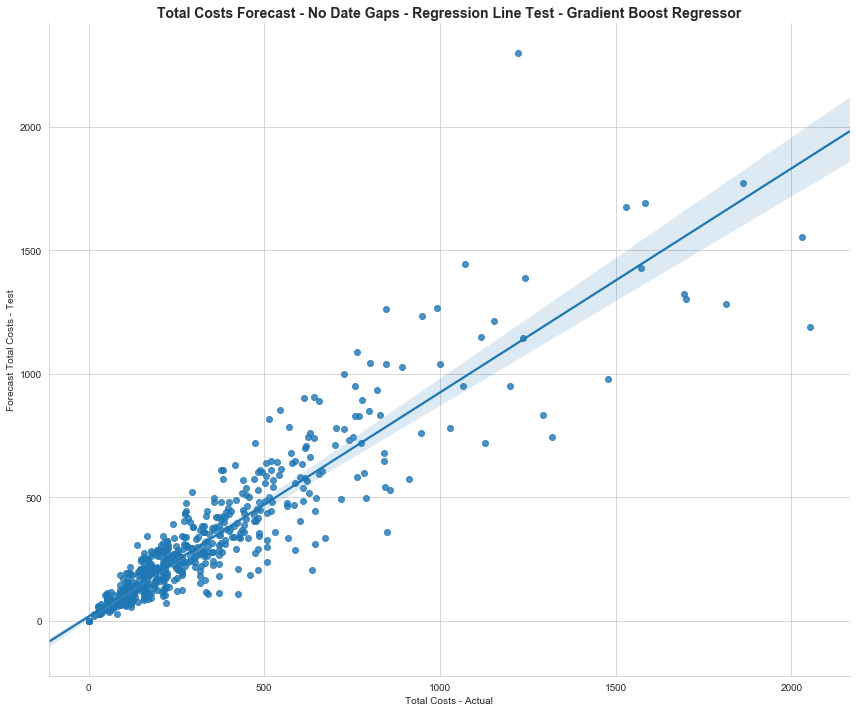

In [112]:
# Graph Test prediction
g = sns.lmplot(x=var_to_predict[0], y='FCST Total Cost Test', data=df_test, height=10, aspect=1.2)
g.set_axis_labels("Total Costs - Actual", "Forecast Total Costs - Test") 
plt.title(var_to_predict_title+ ' - Regression Line Test - Gradient Boost Regressor',
          fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_fcst_test_gbr')
plt.show()

# Random Forest Regressor Model

In [114]:
# Grid Search - Gradient Boosting Regression
np.random.seed(42)
rfr_param_grid = {'n_estimators': [100, 250, 500, 750, 1000],'n_jobs':[10],
                  'max_depth': np.arange(2, 100, 10), 'verbose':[1]
                  "max_features":['auto', 'sqrt', 'log2'],
                  "min_samples_split": [2, 3,5,7],
                  "min_samples_leaf": [1, 3,5,6]
                 }
kfold = KFold(n_splits=num_folds)
rfr = RandomForestRegressor()
# Perform grid search: grid_mse
rfr_grid = GridSearchCV(estimator=rfr, param_grid=rfr_param_grid,
                       scoring=scoring, cv=kfold)
rfr_grid.fit(trainX, trainy)
# Print the best parameters and lowest RMSE
print('Random Forest Regression - Grid Search')
print("Best parameters found: ", rfr_grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(rfr_grid.best_score_)))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 co

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Usi

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 280 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      |

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tas

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    3.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    3.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tas

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      |

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tas

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    4.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    4.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tas

[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    3.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out

[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    4.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 260 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    4.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend Loky

[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    4.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 260 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    5.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 t

[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    3.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 260 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tas

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    4.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    6.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 430 t

[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tas

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    4.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    6.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 t

[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.

[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    3.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend Loky

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    4.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    6.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 t

[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tas

[Parallel(n_jobs=10)]: Done 120 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    4.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    6.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 780 tasks      | ela

[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tas

[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    4.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    5.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 780 tasks      | ela

Random Forest Regression - Grid Search
Best parameters found:  {'max_depth': 92, 'n_estimators': 250, 'n_jobs': 10, 'verbose': 1}
Lowest RMSE found:  0.21648411598594441


[Parallel(n_jobs=10)]: Done 250 out of 250 | elapsed:    1.5s finished


# Observation
These are the best parameters:

First run identifying parameters
    * Best parameters found:  {'max_depth': 92, 'n_estimators': 250, 'n_jobs': 10, 'verbose': 1}
    * Lowest RMSE found:  0.21648411598594441

In [115]:
# Modeling based on the outcome of the grid serach of Random Forest Regressor
rfr = RandomForestRegressor(max_depth=92, n_estimators=250, verbose=0)

rfr.fit(trainX, trainy)

# Predict on test set
yhat_train = rfr.predict(trainX)

# Predict on test set
yhat = rfr.predict(testX)

# Calculate Cross valdation scores
scores_rfr = cross_val_score(rfr, testX, testy, cv=num_folds, scoring=scoring)

print('Random Forest Regressor Train r2 score - Transformed : %.5f' % r2_score(trainy, yhat_train))
print('Random Forest Regressor Test r2 score - Transformed  : %.5f' % r2_score(testy, yhat))
yhat_train_mse1 = mean_squared_error(trainy, yhat_train)
yhat_test_mse1 = mean_squared_error(testy, yhat)
yhat_train_rmse1 = np.sqrt(yhat_train_mse1)
yhat_test_rmse1 = np.sqrt(yhat_test_mse1)
print('Random Forest Regressor Train MSE - Transformed      : %.5f' % yhat_train_mse1)
print('Random Forest Regressor Test MSE - Transformed       : %.5f' % yhat_test_mse1)
print('Random Forest Regressor Train RMSE - Transformed     : %.5f' % yhat_train_rmse1)
print('Random Forest Regressor Test RMSE - Transformed      : %.5f' % yhat_test_rmse1)

# Plot Cross Validation RMSE Scores
fig = px.line(np.sqrt(np.abs(scores_rfr)), y=np.sqrt(np.abs(scores_rfr)), labels={'y':'RMSE'}, title=var_to_predict_title+ ' - RMSE Cross Validation Scores - Transformed')
fig.write_image(var_to_predict_save+'_rfr_crossv.png')
fig.show()

Random Forest Regressor Train r2 score - Transformed : 0.99362
Random Forest Regressor Test r2 score - Transformed  : 0.95843
Random Forest Regressor Train MSE - Transformed      : 0.00631
Random Forest Regressor Test MSE - Transformed       : 0.04250
Random Forest Regressor Train RMSE - Transformed     : 0.07947
Random Forest Regressor Test RMSE - Transformed      : 0.20615


In [116]:
# Untransformed series
un_trainy = trainy.copy()
un_trainy[var_to_predict] = scaler_y.inverse_transform(un_trainy) 

un_testy = testy.copy()
un_testy[var_to_predict] = scaler_y.inverse_transform(un_testy) 

un_yhat_train = pd.DataFrame(data=scaler_y.inverse_transform(yhat_train.reshape(-1, 1)), 
                                  index=trainy.index, columns=var_to_predict) 

un_yhat = pd.DataFrame(data=scaler_y.inverse_transform(yhat.reshape(-1, 1)), 
                                  index=testy.index, columns=var_to_predict) 

# Build Training Dataframe
df_train = un_trainy.copy()
df_train['FCST Total Cost Train'] = un_yhat_train[var_to_predict]
df_train['FCST Error Train'] = un_yhat_train[var_to_predict]
df_train['FCST Error Train'] -= df_train['FCST Total Cost Train']

# Build test dataframe
df_test = un_testy.copy()
df_test['FCST Total Cost Test'] = un_yhat[var_to_predict]
df_test['FCST Error Test'] = df_test[var_to_predict]
df_test['FCST Error Test'] -= df_test['FCST Total Cost Test']

print('Random Forest Regressor Train r2 score         : %.5f' % r2_score(un_trainy, un_yhat_train))
print('Random Forest Regressor Test  r2 score         : %.5f' % r2_score(un_testy, un_yhat))
un_yhat_train_mse1 = mean_squared_error(un_trainy, un_yhat_train)
un_yhat_test_mse1 = mean_squared_error(un_testy, un_yhat)
un_yhat_train_rmse1 = np.sqrt(un_yhat_train_mse1)
un_yhat_test_rmse1 = np.sqrt(un_yhat_test_mse1)
print('Random Forest Regressor  Train MSE             : %.5f' % un_yhat_train_mse1)
print('Random Forest Regressor  Test MSE              : %.5f' % un_yhat_test_mse1)
print('Random Forest Regressor  Train RMSE            : %.5f' % un_yhat_train_rmse1)
print('Random Forest Regressor  Test RMSE             : %.5f' % un_yhat_test_rmse1)
print('Random Forest Regressor  Train Mean FCST Error : %.5f' % df_train['FCST Error Train'].mean())
print('Random Forest Regressor  Test Mean FCST Error  : %.5f' % df_test['FCST Error Test'].mean())

Random Forest Regressor Train r2 score         : 0.97562
Random Forest Regressor Test  r2 score         : 0.84902
Random Forest Regressor  Train MSE             : 1809.60479
Random Forest Regressor  Test MSE              : 12284.02733
Random Forest Regressor  Train RMSE            : 42.53945
Random Forest Regressor  Test RMSE             : 110.83333
Random Forest Regressor  Train Mean FCST Error : 0.00000
Random Forest Regressor  Test Mean FCST Error  : 10.33616


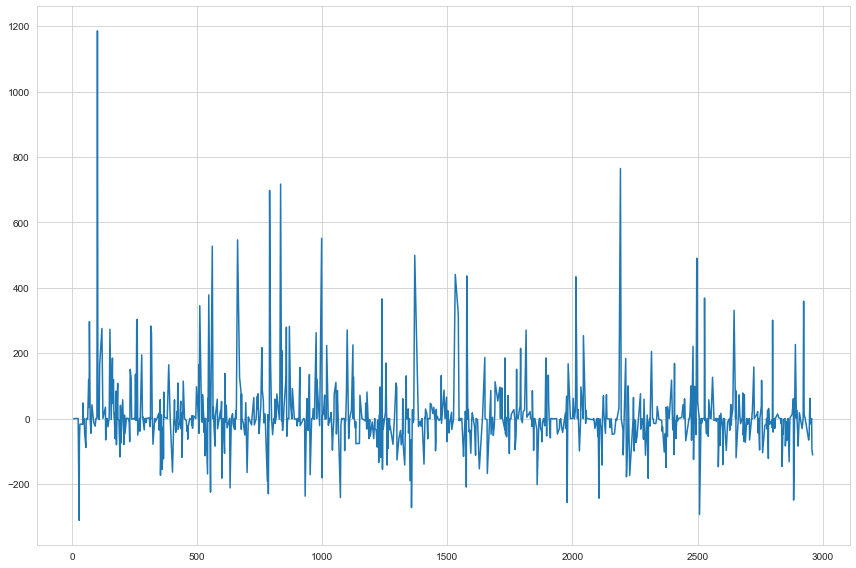

In [117]:
sns.lineplot(data=df_test['FCST Error Test'])
plt.show()

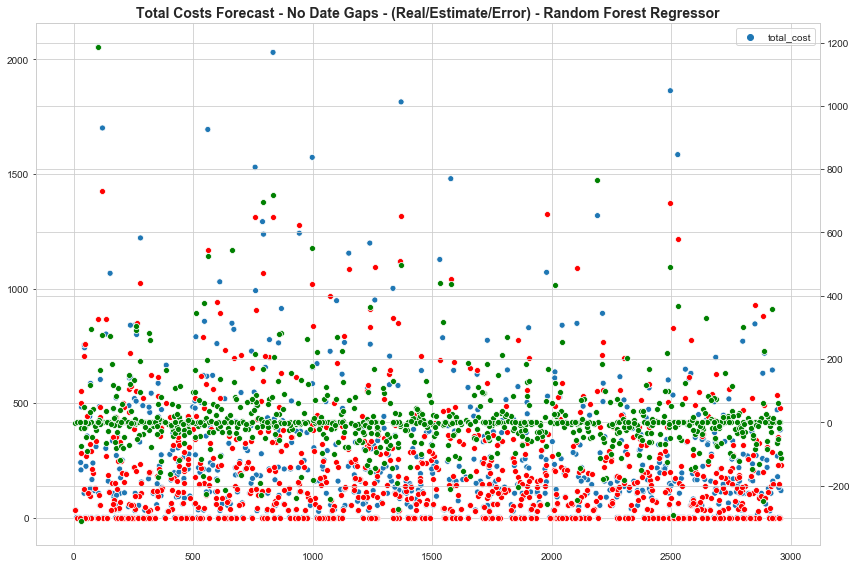

In [118]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.scatterplot(data=df_test[var_to_predict], color="b", legend='full', ax=ax1)
sns.scatterplot(data=df_test['FCST Total Cost Test'], color="r", legend='full', ax=ax1)
sns.scatterplot(data=df_test['FCST Error Test'], color="g", legend='full', ax=ax2)
plt.title(var_to_predict_title+ ' - (Real/Estimate/Error) - Random Forest Regressor',
          fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_scatter_rfr')
plt.show()

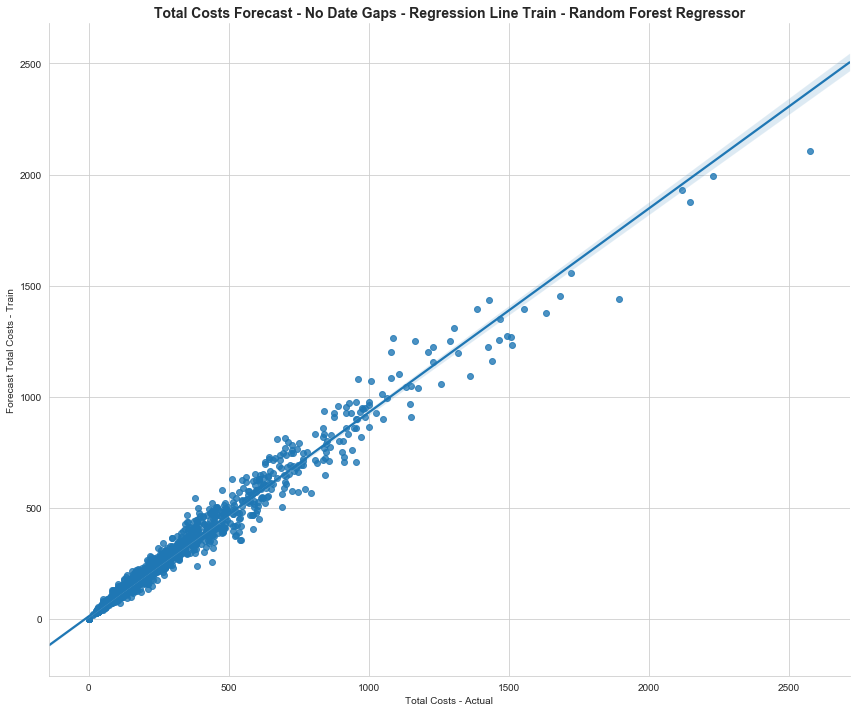

In [119]:
# Graph Train prediction
sns.set_style("whitegrid", {'axes.grid' : True})
g = sns.lmplot(x=var_to_predict[0], y='FCST Total Cost Train', data=df_train, height=10, aspect=1.2)
g.set_axis_labels("Total Costs - Actual", "Forecast Total Costs - Train") 
plt.title(var_to_predict_title+ ' - Regression Line Train - Random Forest Regressor',fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_fcst_train_rfr')
plt.show()

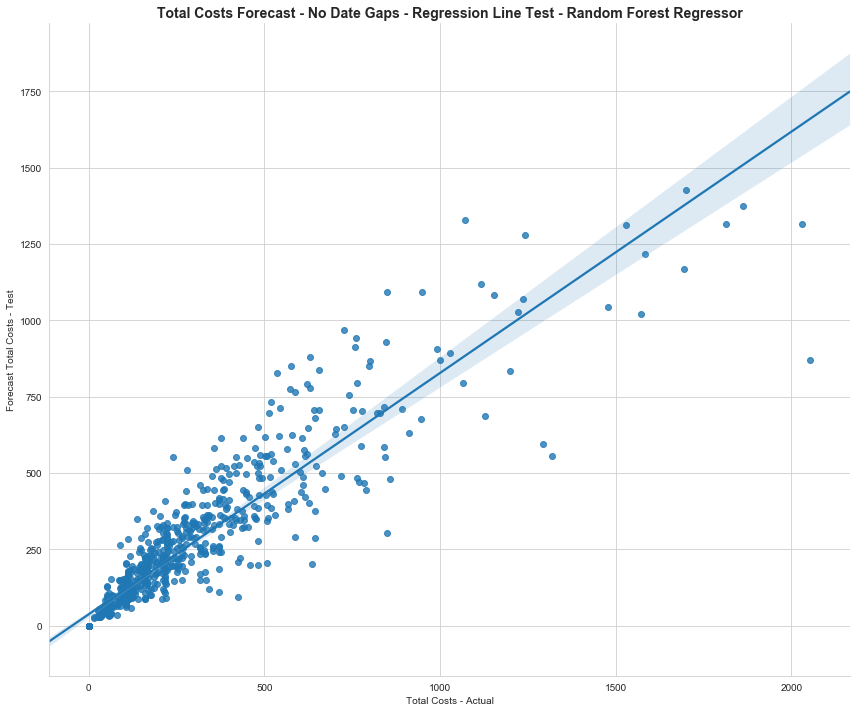

In [120]:
# Graph Test prediction
g = sns.lmplot(x=var_to_predict[0], y='FCST Total Cost Test', data=df_test, height=10, aspect=1.2)
g.set_axis_labels("Total Costs - Actual", "Forecast Total Costs - Test") 
plt.title(var_to_predict_title+ ' - Regression Line Test - Random Forest Regressor',
          fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_fcst_test_rfr')
plt.show()

# Bagging Regressor model

In [ ]:
# Bagging Regressor
np.random.seed(42)

#create a dictionary of all values we want to test
param_grid = {'max_samples': np.arange(1, 50,5),
              'max_features': np.arange(1, 250,10),
              "n_estimators": [50,100,200],
              "bootstrap": [True, False],
              "bootstrap_features": [True, False]
             }

# bagging regresssor
bgr = BaggingRegressor()

#use gridsearch to test all values
bgr_gscv = GridSearchCV(bgr, param_grid, cv=num_folds)

#fit model to data
bgr_gscv.fit(trainX, trainy)
print('Bagging Regression - Grid Search')
print("Best parameters found: ", bgr_grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(bgr_grid.best_score_)))

# Observation

Based on the grid search above, the best parameter for the Decission Tree Classifier is:
* The 1st run showed 
    * Best parameters :  {'criterion': 'gini', 'max_depth': 52}
    * Best Score      :  0.7829467396714784
    * As I am using an increment of 10, rerun it, using increment of 1 from +-10

* Narrowing the parameters
    * Best parameters :  {'criterion': 'gini', 'max_depth': 61}
    * Best Score      :  0.785792268126763

In [ ]:
# Modeling based on the outcome of the grid serach of Random Forest Regressor
bgr = RandomForestRegressor(max_depth=92, n_estimators=250, verbose=0)

bgr.fit(trainX, trainy)

# Predict on test set
yhat_train = bgr.predict(trainX)

# Predict on test set
yhat = bgr.predict(testX)

# Calculate Cross valdation scores
scores_bgr = cross_val_score(bgr, testX, testy, cv=num_folds, scoring=scoring)

print('Bagging Regressor Train r2 score - Transformed : %.5f' % r2_score(trainy, yhat_train))
print('Bagging Regressor Test r2 score - Transformed  : %.5f' % r2_score(testy, yhat))
yhat_train_mse1 = mean_squared_error(trainy, yhat_train)
yhat_test_mse1 = mean_squared_error(testy, yhat)
yhat_train_rmse1 = np.sqrt(yhat_train_mse1)
yhat_test_rmse1 = np.sqrt(yhat_test_mse1)
print('Bagging Regressor Train MSE - Transformed      : %.5f' % yhat_train_mse1)
print('Bagging Regressor Test MSE - Transformed       : %.5f' % yhat_test_mse1)
print('Bagging Regressor Train RMSE - Transformed     : %.5f' % yhat_train_rmse1)
print('Bagging Regressor Test RMSE - Transformed      : %.5f' % yhat_test_rmse1)

# Plot Cross Validation RMSE Scores
fig = px.line(np.sqrt(np.abs(scores_bgr)), y=np.sqrt(np.abs(scores_bgr)), labels={'y':'RMSE'}, title=var_to_predict_title+ ' - RMSE Cross Validation Scores - Transformed')
fig.write_image(var_to_predict_save+'_bgr_crossv.png')
fig.show()

In [ ]:
# Untransformed series
un_trainy = trainy.copy()
un_trainy[var_to_predict] = scaler_y.inverse_transform(un_trainy) 

un_testy = testy.copy()
un_testy[var_to_predict] = scaler_y.inverse_transform(un_testy) 

un_yhat_train = pd.DataFrame(data=scaler_y.inverse_transform(yhat_train.reshape(-1, 1)), 
                                  index=trainy.index, columns=var_to_predict) 

un_yhat = pd.DataFrame(data=scaler_y.inverse_transform(yhat.reshape(-1, 1)), 
                                  index=testy.index, columns=var_to_predict) 

# Build Training Dataframe
df_train = un_trainy.copy()
df_train['FCST Total Cost Train'] = un_yhat_train[var_to_predict]
df_train['FCST Error Train'] = un_yhat_train[var_to_predict]
df_train['FCST Error Train'] -= df_train['FCST Total Cost Train']

# Build test dataframe
df_test = un_testy.copy()
df_test['FCST Total Cost Test'] = un_yhat[var_to_predict]
df_test['FCST Error Test'] = df_test[var_to_predict]
df_test['FCST Error Test'] -= df_test['FCST Total Cost Test']

print('Bagging Regressor Train r2 score         : %.5f' % r2_score(un_trainy, un_yhat_train))
print('Bagging Regressor Test  r2 score         : %.5f' % r2_score(un_testy, un_yhat))
un_yhat_train_mse1 = mean_squared_error(un_trainy, un_yhat_train)
un_yhat_test_mse1 = mean_squared_error(un_testy, un_yhat)
un_yhat_train_rmse1 = np.sqrt(un_yhat_train_mse1)
un_yhat_test_rmse1 = np.sqrt(un_yhat_test_mse1)
print('Bagging Regressor  Train MSE             : %.5f' % un_yhat_train_mse1)
print('Bagging Regressor  Test MSE              : %.5f' % un_yhat_test_mse1)
print('Bagging Regressor  Train RMSE            : %.5f' % un_yhat_train_rmse1)
print('Bagging Regressor  Test RMSE             : %.5f' % un_yhat_test_rmse1)
print('Bagging Regressor  Train Mean FCST Error : %.5f' % df_train['FCST Error Train'].mean())
print('Bagging Regressor  Test Mean FCST Error  : %.5f' % df_test['FCST Error Test'].mean())

In [ ]:
sns.lineplot(data=df_test['FCST Error Test'])
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.scatterplot(data=df_test[var_to_predict], color="b", legend='full', ax=ax1)
sns.scatterplot(data=df_test['FCST Total Cost Test'], color="r", legend='full', ax=ax1)
sns.scatterplot(data=df_test['FCST Error Test'], color="g", legend='full', ax=ax2)
plt.title(var_to_predict_title+ ' - (Real/Estimate/Error) - Bagging Regressor',
          fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_scatter_bgr')
plt.show()

In [ ]:
# Graph Train prediction
sns.set_style("whitegrid", {'axes.grid' : True})
g = sns.lmplot(x=var_to_predict[0], y='FCST Total Cost Train', data=df_train, height=10, aspect=1.2)
g.set_axis_labels("Total Costs - Actual", "Forecast Total Costs - Train") 
plt.title(var_to_predict_title+ ' - Regression Line Train - Bagging Regressor',fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_fcst_train_bgr')
plt.show()

In [ ]:
# Graph Test prediction
g = sns.lmplot(x=var_to_predict[0], y='FCST Total Cost Test', data=df_test, height=10, aspect=1.2)
g.set_axis_labels("Total Costs - Actual", "Forecast Total Costs - Test") 
plt.title(var_to_predict_title+ ' - Regression Line Test - Bagging Regressor',
          fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_fcst_test_bgr')
plt.show()

# Feature importance in trees
feature importance rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [ ]:
coef_df_cart = pd.DataFrame({'feature':testX.columns, 'coefs': cart.feature_importances_})
coef_df_cart["abs_coeff"] = coef_df_cart['coefs'].abs()
coef_df_cart.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_cart.nlargest(30,columns=["abs_coeff"])
counts_cart = pd.DataFrame(coef_df_cart.nlargest(30,columns=["abs_coeff"]), index=None)
counts_cart.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_cart, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_cart_coef.png')
py.iplot(fig)

In [ ]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of CART Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_cart['Features (MinMax Transformer)'], x=counts_cart['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_cart_coef_1')
plt.show()

# Random Forest Classifier Model

In [ ]:
np.random.seed(42)
num_folds = 10
scoring = 'accuracy'
#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 200, 8)}

# Random Forest Classifier model
rf = RandomForestClassifier()

#use gridsearch to test all values
rf_gscv = GridSearchCV(rf, param_grid, cv=num_folds, scoring=scoring)

#fit model to data
rf_gscv.fit(trainX, trainy)
print('Best parameters : ', rf_gscv.best_params_)
print('Best score      : ', rf_gscv.best_score_)

# Observation
Based on the grid search above, th best parameter for the Random Forest Classifier is:
* The 1st run showed a max_depth of 112, with gini, as I am using an increment of 10, rerun it, using increment of 1 from +-10
    * Best parameters :  {'criterion': 'gini', 'max_depth': 42}
    * Best score      :  0.8541958041958042
* Narrowing the search around the best parameter of the 1st search
    * Best parameters :  {'criterion': 'entropy', 'max_depth': 32}
    * Best score      :  0.8545454545454545

In [ ]:
# Modeling based on the outcome of the grid serach of the random forest
rf = DecisionTreeClassifier(criterion = 'gini', max_depth=130)
rf.fit(trainX, trainy)

# Predict on test set
yhat = rf.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
rf_probs = rf.predict_proba(testX)

# Keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
rf_auc = roc_auc_score(testy, rf_probs)

# Calculate Cross valdation scores
rf_scores = cross_val_score(rf, testX, testy, cv=num_folds)

print("Random Forest - Accuracy on training set: {:.3f}".format(rf.score(trainX, trainy)))
print("Random Forest - Accuracy on test set: {:.3f}".format(rf.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Random Forest - Precision                  : %.3f' % precision_score(testy, yhat))
print('Random Forest - Recall                     : %.3f' % recall_score(testy, yhat))
print('Random Forest - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Random Forest - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Random Forest - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Random Forest - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Random Forest - ROC AUC                    : %.3f' % (rf_auc))
print("Random Forest - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (rf_scores.mean(), rf_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(testy, rf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Random Forest - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_rf_roc')
plt.show()

In [ ]:
# Train / Cross Validation Score Plot
skplt.estimators.plot_learning_curve(rf, trainX, trainy, cv=num_folds, title=var_to_predict_title + ' - Random Forest - Train / Cross Validation Score Plot')
plt.savefig(var_to_predict_save+'_rf_txcval')
plt.show()

# Cummulative Gain Plot
skplt.metrics.plot_cumulative_gain(testy,rf.predict_proba(testX), title=var_to_predict_title + ' - Random Forest - Cummulative Gains Curve')
plt.savefig(var_to_predict_save+'_rf_cgc')
plt.show()

# Lift Curve Plot
skplt.metrics.plot_lift_curve(testy,rf.predict_proba(testX), title=var_to_predict_title + ' - Random Forest - Lift Curve')
plt.savefig(var_to_predict_save+'_rf_liftc')
plt.show()

# Precision - Recall Curve
skplt.metrics.plot_precision_recall_curve(testy,rf.predict_proba(testX), title=var_to_predict_title + ' - Random Forest - Precision - Recall Curve')
plt.savefig(var_to_predict_save+'_rf_prerecc')
plt.show()

# KS statistics Plot
skplt.metrics.plot_ks_statistic(testy, rf.predict_proba(testX), title=var_to_predict_title+' - Random Forest - KS Statistics Plot')
plt.savefig(var_to_predict_save+'_rf_ksst')
plt.show()

In [ ]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1 
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+ ", without normalization - Random Forest", None),
                  ("Normalized confusion matrix - "+var_to_predict_title+" - Random Forest", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_rf_cm')
    else: plt.savefig(var_to_predict_save+'_rf_cm_1')
    i +=1
    plt.show()

# Feature importance
feature importance rates how important each feature is for the random forest tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [ ]:
coef_df_rf = pd.DataFrame({'feature':testX.columns, 'coefs': rf.feature_importances_})
coef_df_rf["abs_coeff"] = coef_df_rf['coefs'].abs()
coef_df_rf.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_rf.nlargest(30,columns=["abs_coeff"])
counts_rf = pd.DataFrame(coef_df_rf.nlargest(30,columns=["abs_coeff"]), index=None)
counts_rf.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_rf, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_rf_coef.png')
py.iplot(fig)

In [ ]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Random Forest Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_rf['Features (MinMax Transformer)'], x=counts_rf['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_rf_coef_1')
plt.show()

# ExtraTreesClassifier Classifier

In [ ]:
np.random.seed(42)
#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 200,10), 'n_estimators': np.arange(10, 200, 10)}

# Random Forest Classifier model
et = ExtraTreesClassifier()

#use gridsearch to test all values
et_gscv = GridSearchCV(et, param_grid, cv=num_folds, scoring=scoring)

#fit model to data
et_gscv.fit(trainX, trainy)
print('Best parameters : ', et_gscv.best_params_)
print('Best score      : ', et_gscv.best_score_)

# Observation
Based on the grid search above, th best parameter for the Random Forest Classifier is:
* The 1st run showed a max_depth of 32, with gini, as I am using an increment of 10, rerun it, using increment of 1 from +-10
    * Best parameters :  {'criterion': 'gini', 'max_depth': 92, 'n_estimators': 120}
    * Best score      :  0.8388485150157624
* Narrowing the search around the best parameter of the 1st search
    * Best parameters :  {'criterion': 'entropy', 'max_depth': 42}
    * Best score      :  0.855944055944056

In [ ]:
# Modeling based on the outcome of the grid serach of the random forest
et = ExtraTreesClassifier(criterion = 'gini', max_depth=92, n_estimators=120)
et.fit(trainX, trainy)

# Predict on test set
yhat = et.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
et_probs = et.predict_proba(testX)

# Keep probabilities for the positive outcome only
et_probs = et_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
et_auc = roc_auc_score(testy, et_probs)

# Calculate Cross valdation scores
scores_et = cross_val_score(et, testX, testy, cv=num_folds)

print("Extra Tree Classifier - Accuracy on training set: {:.3f}".format(et.score(trainX, trainy)))
print("Extra Tree Classifier - Accuracy on test set: {:.3f}".format(et.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Extra Tree Classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('Extra Tree Classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('Extra Tree Classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Extra Tree Classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Extra Tree Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Extra Tree Classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Extra Tree Classifier - ROC AUC                    : %.3f' % (et_auc))
print("Extra Tree Classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores_et.mean(), scores_et.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
et_fpr, et_tpr, _ = roc_curve(testy, et_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(et_fpr, et_tpr, marker='.', label='Extra Tree Classifier - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Extra Tree Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_et_roc')
plt.show()

In [ ]:
# Train / Cross Validation Score Plot
skplt.estimators.plot_learning_curve(et, trainX, trainy, cv=num_folds, title=var_to_predict_title + ' - Extra Tree Classifier - Train / Cross Validation Score Plot')
plt.savefig(var_to_predict_save+'_et_txcval')
plt.show()

# Cummulative Gain Plot
skplt.metrics.plot_cumulative_gain(testy,et.predict_proba(testX), title=var_to_predict_title + ' - Extra Tree Classifier - Cummulative Gains Curve')
plt.savefig(var_to_predict_save+'_et_cgc')
plt.show()

# Lift Curve Plot
skplt.metrics.plot_lift_curve(testy,et.predict_proba(testX), title=var_to_predict_title + ' - Extra Tree Classifier - Lift Curve')
plt.savefig(var_to_predict_save+'_et_liftc')
plt.show()

# Precision - Recall Curve
skplt.metrics.plot_precision_recall_curve(testy,et.predict_proba(testX), title=var_to_predict_title + ' - Extra Tree Classifier - Precision - Recall Curve')
plt.savefig(var_to_predict_save+'_et_prerecc')
plt.show()

# KS statistics Plot
skplt.metrics.plot_ks_statistic(testy, et.predict_proba(testX), title=var_to_predict_title+' - Extra Tree Classifier - KS Statistics Plot')
plt.savefig(var_to_predict_save+'_et_ksst')
plt.show()

In [ ]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - Extra Tree Classifier", None),
                  ("Extra Tree Classifier - Normalized confusion matrix - "+var_to_predict_title, 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(et, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_et_cm')
    else: plt.savefig(var_to_predict_save+'_et_cm_1')
    i +=1
    plt.show()

In [ ]:
coef_df_et = pd.DataFrame({'feature':testX.columns, 'coefs': et.feature_importances_})
coef_df_et["abs_coeff"] = coef_df_et['coefs'].abs()
coef_df_et.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_et.nlargest(30,columns=["abs_coeff"])
counts_et = pd.DataFrame(coef_df_et.nlargest(30,columns=["abs_coeff"]), index=None)
counts_et.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_et, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_et_coef.png')
py.iplot(fig)

In [ ]:
df_cumsum = coef_df_et.copy()
df_cumsum.set_index('feature', inplace=True)
df_cumsum.abs_coeff.cumsum().plot(kind='barh', figsize=(12,10))
plt.xticks(
            rotation=90, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='small')
plt.show()

In [ ]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Extra Tree Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_et['Features (MinMax Transformer)'], x=counts_et['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_et_coef_1')
plt.show()

# XGBOOSTING Modeling

In [ ]:
np.random.seed(42)
scoring = 'accuracy'

#create a dictionary of all values we want to test
param_grid = {'max_depth': [5,6,7, 8], 'n_estimators': range(50, 250, 50), 
              'learning_rate': [0.1, 0.01, 0.05], 'min_child_weight':[2,4, 6],
              'gamma':[0.1]
             }
# CV model
xgb = XGBClassifier(objective= 'binary:logistic',nthread=4)
kfold = KFold(n_splits=num_folds)
xgb_gscv = GridSearchCV(estimator=xgb,param_grid=param_grid, scoring = scoring, 
                        n_jobs = 10, cv = kfold,verbose=True
                       )
xgb_gscv.fit(trainX, trainy)
print('Best parameters - : ', xgb_gscv.best_params_)
print('Best score      : ', xgb_gscv.best_score_)

# Observation
Best parameters - :  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 200}
Best score      :  0.9773189547971137

In [ ]:
# Modeling based on the outcome of the grid serach of the random forest
xgb = XGBClassifier(objective= 'binary:logistic',nthread=4, gamma=0.1,
                          learning_rate=0.1, max_depth=8, min_child_weight=2,
                          n_estimators=200                        
                         )
xgb.fit(trainX, trainy)

# Predict on test set
yhat = xgb.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
xgb_probs = xgb.predict_proba(testX)

# Keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
xgb_auc = roc_auc_score(testy, xgb_probs)

# Calculate Cross valdation scores
scores_xgb = cross_val_score(xgb, testX, testy, cv=num_folds)

print("XGBoost Classifier - Accuracy on training set: {:.3f}".format(xgb.score(trainX, trainy)))
print("XGBoost Classifier - Accuracy on test set: {:.3f}".format(xgb.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('XGBoost Classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('XGBoost Classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('XGBoost Classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('XGBoost Classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('XGBoost Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('XGBoost Classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('XGBoost Classifier - ROC AUC                    : %.3f' % (xgb_auc))
print("XGBoost Classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(testy, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost Classifier - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('XGBooster Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_xgb_roc')
plt.show()

In [ ]:
# Train / Cross Validation Score Plot
skplt.estimators.plot_learning_curve(xgb, trainX, trainy, cv=num_folds, title=var_to_predict_title + ' - XGBoost Classifier - Train / Cross Validation Score Plot')
plt.savefig(var_to_predict_save+'_xgb_txcval')
plt.show()

# Cummulative Gain Plot
skplt.metrics.plot_cumulative_gain(testy,xgb.predict_proba(testX), title=var_to_predict_title + ' - XGBoost Classifier - Cummulative Gains Curve')
plt.savefig(var_to_predict_save+'_xgb_cgc')
plt.show()

# Lift Curve Plot
skplt.metrics.plot_lift_curve(testy,xgb.predict_proba(testX), title=var_to_predict_title + ' - XGBoost Classifier - Lift Curve')
plt.savefig(var_to_predict_save+'_xgb_liftc')
plt.show()

# Precision - Recall Curve
skplt.metrics.plot_precision_recall_curve(testy,xgb.predict_proba(testX), title=var_to_predict_title + ' - XGBoost Classifier - Precision - Recall Curve')
plt.savefig(var_to_predict_save+'_xgb_prerecc')
plt.show()

# KS statistics Plot
skplt.metrics.plot_ks_statistic(testy, xgb.predict_proba(testX), title=var_to_predict_title+' - XGBoost Classifier - KS Statistics Plot')
plt.savefig(var_to_predict_save+'_xgb_ksst')
plt.show()

In [ ]:
coef_df_xgb = pd.DataFrame({'feature':testX.columns, 'coefs': xgb.feature_importances_})
coef_df_xgb["abs_coeff"] = coef_df_xgb['coefs'].abs()
coef_df_xgb.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_xgb.nlargest(30,columns=["abs_coeff"])
counts_xgb = pd.DataFrame(coef_df_xgb.nlargest(30,columns=["abs_coeff"]), index=None)
counts_xgb.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_xgb, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_xgb_coef.png')
py.iplot(fig)

In [ ]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of XGBooster Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_xgb['Features (MinMax Transformer)'], x=counts_xgb['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_xgb_coef_1')
plt.show()

# Keras Modeling

In [ ]:
# Keras Classifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD


np.random.seed(42)
# Create input and output dataframes

num_folds = 10
scoring = 'accuracy'

# create model
keras_nn = Sequential()
keras_nn.add(Dense(trainX.shape[1], input_dim=trainX.shape[1], activation='relu'))
keras_nn.add(Dropout(0.2))
keras_nn.add(Dense(int(trainX.shape[1]/2), activation='relu'))
keras_nn.add(Dense(1, activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.01, momentum=0.8)
keras_nn.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[scoring])
# Fit the model
history = keras_nn.fit(trainX, trainy, validation_data=(testX,testy), epochs=150, batch_size=10, verbose=1)
# evaluate the model
scores = keras_nn.evaluate(trainX, trainy, verbose=0)
print("Keras - Accuracy Train Set : %.3f" % scores[1])
scores = keras_nn.evaluate(testX, testy, verbose=0)
print("Keras - Accuracy Test Set  : %.3f" % scores[1])

In [ ]:
# Visualize training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Keras Model accuracy - '+var_to_predict_title )
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(var_to_predict_save+'_keras_model_1')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras Model Loss - '+ var_to_predict_title)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(var_to_predict_save+'_keras_model_2')
plt.show()

# Not used from this point below. 

# SVM Model

In [ ]:
# SVM grid search evaluation

np.random.seed(42)
num_folds = 10
scoring = 'accuracy'

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0, 2.3, 2.5, 2.7, 3.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
svc = SVC(gamma='auto')
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=svc, param_grid=param_grid, scoring=scoring, cv=kfold, iid=True)
grid_result = grid.fit(trainX, trainy)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Scaler Testing

In [ ]:
# Scale fields using Standard Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Standard Scaler
scaler = StandardScaler()
scaled_df_std = scaler.fit_transform(df)
scaled_df_std = pd.DataFrame(scaled_df_std, columns=features_to_scale)


for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    
    ax1.set_title('Before Scaling Standard Scaler')
    ax2.set_title('After Standard Scaler')

    sns.kdeplot(df[col], ax=ax1)
    sns.kdeplot(scaled_df_std[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_std.describe()

In [ ]:
# Scale fields using Min-Max scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Min-Max Scaler
scaler = MinMaxScaler()
scaled_df_mm = scaler.fit_transform(df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=features_to_scale)

for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Min-Max')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Min-Max Scaling')
    sns.kdeplot(scaled_df_mm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_mm.describe()

In [ ]:
# Scale fields using Robust Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Robust Scaler- excellent with outliers
scaler = RobustScaler()
scaled_df_rs = scaler.fit_transform(df)
scaled_df_rs = pd.DataFrame(scaled_df_rs, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Robust Scaling')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Robust Scaling')
    sns.kdeplot(scaled_df_rs[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_rs.describe()

In [ ]:
# Scale fields using Normalizer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Normalizer
scaler = Normalizer()
scaled_df_nm = scaler.fit_transform(df)
scaled_df_nm = pd.DataFrame(scaled_df_nm, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Normalizer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Normalizer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_nm.describe()

In [ ]:
# Scale fields using Quantile Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# QuantileTransformer
scaler = QuantileTransformer(n_quantiles=200, output_distribution='normal')
scaled_df_qt = scaler.fit_transform(df)
scaled_df_qt = pd.DataFrame(scaled_df_qt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling QuantileTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After QuantileTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_qt.describe()

In [ ]:
# Scale fields using Power Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# PowerTransformer
scaler = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
scaled_df_pt = scaler.fit_transform(df)
scaled_df_pt = pd.DataFrame(scaled_df_pt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling PowerTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After PowerTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_pt.describe()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_test_over[var_to_predict[0]].values)
plt.xlabel('Row number')
plt.ylabel('y value')
plt.title('Change in y value over the data set')
plt.show();